In [216]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as cls
import seaborn as sns
import numpy as np
from pathlib import Path
from urllib.parse import urlparse
import glob
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Definitions

In [155]:
"""=== NATURE FORMAT CONFIGURATION ==="""
# Set these once at the beginning for all plots in the notebook

# Font settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']  # Fallback fonts
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams['figure.titlesize'] = 9

# Line and spine settings
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5

# Grid settings
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.3

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.05

# Remove top and right spines by default
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Nature figure widths (in inches) - these stay the same
SINGLE_COL = 3.5   # 89 mm
ONE_HALF_COL = 4.7  # 120 mm
DOUBLE_COL = 7.2   # 183 mm

print("✓ Nature format configuration loaded")
print(f"  Single column width: {SINGLE_COL}\"")
print(f"  1.5 column width: {ONE_HALF_COL}\"")
print(f"  Double column width: {DOUBLE_COL}\"")

✓ Nature format configuration loaded
  Single column width: 3.5"
  1.5 column width: 4.7"
  Double column width: 7.2"


# Load CSVs

In [217]:
"""Load all CSV files from the folder structure"""
print("Loading data from all CSV files...")

# Load LessWrong data
forum = 'lesswrong'
lw_files = glob.glob(f"../src/processed_data/{forum}/03_with_topics/**/*.csv", recursive=True)
print(f"Found {len(lw_files)} LessWrong CSV files")

lw_data = []
for file in lw_files:
    try:
        df = pd.read_csv(file)
        # Extract year and month from filename
        parts = Path(file).stem.split('-')
        if len(parts) >= 2:
            df['year'] = int(parts[0])
            df['month'] = int(parts[1])
        lw_data.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not lw_data:
    print("No LessWrong data found! Check your file paths.")
else:
    lesswrong_df = pd.concat(lw_data, ignore_index=True)
    print(f"Loaded {len(lesswrong_df)} total LessWrong posts from {len(lw_data)} files")
    
    # Clean and prepare LessWrong data
    lesswrong_df['postedAt'] = pd.to_datetime(lesswrong_df['postedAt'], errors='coerce')
    lesswrong_df['baseScore'] = pd.to_numeric(lesswrong_df['baseScore'], errors='coerce').fillna(0)
    lesswrong_df['commentCount'] = pd.to_numeric(lesswrong_df['commentCount'], errors='coerce').fillna(0)

# Load Alignment Forum data
forum = 'alignment_forum'
af_files = glob.glob(f"../src/processed_data/{forum}/03_with_topics/**/*.csv", recursive=True)
print(f"Found {len(af_files)} Alignment Forum CSV files")

af_data = []
for file in af_files:
    try:
        df = pd.read_csv(file)
        # Extract year and month from filename
        parts = Path(file).stem.split('-')
        if len(parts) >= 2:
            df['year'] = int(parts[0])
            df['month'] = int(parts[1])
        af_data.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not af_data:
    print("No Alignment Forum data found! Check your file paths.")
else:
    alignment_forum_df = pd.concat(af_data, ignore_index=True)
    print(f"Loaded {len(alignment_forum_df)} total Alignment Forum posts from {len(af_data)} files")
    
    # Clean and prepare Alignment Forum data
    alignment_forum_df['postedAt'] = pd.to_datetime(alignment_forum_df['postedAt'], errors='coerce')
    alignment_forum_df['baseScore'] = pd.to_numeric(alignment_forum_df['baseScore'], errors='coerce').fillna(0)
    alignment_forum_df['commentCount'] = pd.to_numeric(alignment_forum_df['commentCount'], errors='coerce').fillna(0)

# Optional: Create combined dataframe with platform identifier
combined_df = pd.concat([
    lesswrong_df.assign(platform='LessWrong'),
    alignment_forum_df.assign(platform='Alignment Forum')
], ignore_index=True)
print(f"\nCombined total: {len(combined_df)} posts across both platforms")

Loading data from all CSV files...
Found 198 LessWrong CSV files
Loaded 45357 total LessWrong posts from 198 files
Found 126 Alignment Forum CSV files
Loaded 4230 total Alignment Forum posts from 126 files

Combined total: 49587 posts across both platforms


---
# Forum Nodes
---

In [ ]:
def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=256):
    """Helper function to truncate colormap."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{min_val:.2f},{max_val:.2f})',
        cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

## Topic Analysis


--- Analyzing LessWrong ---


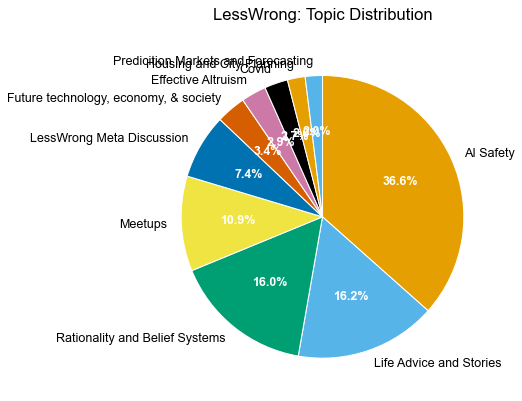

Saved: img/topic_analysis_lesswrong.pdf
Topics found: 10
Total posts: 43675

--- Analyzing Alignment Forum ---


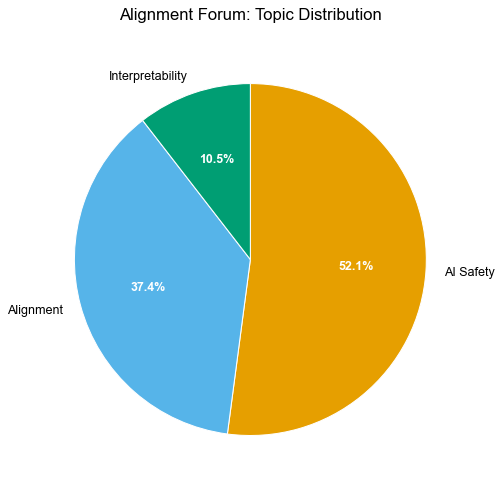

Saved: img/topic_analysis_lesswrong.pdf
Topics found: 3
Total posts: 4149

--- Creating combined comparison ---


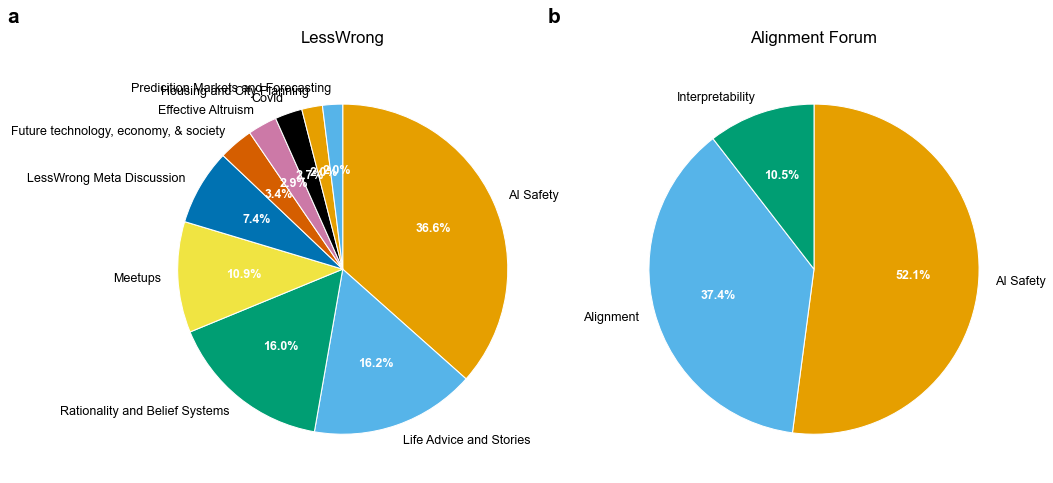

In [ ]:
"""=== TOPIC ANALYSIS ==="""

# Plot for both platforms
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df)]:
    
    print(f"\n--- Analyzing {platform_name} ---")
    
    # Filter out Misc topics
    filtered_df = platform_df[platform_df["topic_label"] != 'Misc: No Topic'].copy()
    
    if len(filtered_df) == 0:
        print(f"No topics found for {platform_name}")
        continue
    
    # Get topic counts
    topic_counts = filtered_df["topic_label"].value_counts()
    
    # --- Figure: Topic distribution pie chart (Nature format) ---
    fig, ax = plt.subplots(figsize=(3.5, 3.5))  # Single column width (89mm)
    
    wedges, texts, autotexts = ax.pie(
        topic_counts.values,
        labels=topic_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        colors=okabe_ito_palette[:len(topic_counts)],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        textprops={'fontsize': 6}  # Small font for labels
    )
    
    # Format percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(6)
        autotext.set_weight('bold')
    
    # Format labels
    for text in texts:
        text.set_fontsize(6)
    
    ax.set_title(f"{platform_name}: Topic Distribution", fontsize=8, pad=10)
    
    plt.tight_layout()
    
    plt.show()
    
    print(f"Topics found: {len(topic_counts)}")
    print(f"Total posts: {len(filtered_df)}")

# --- Combined plot for both platforms (Nature double-column format) ---
print("\n--- Creating combined comparison ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.5))  # Double column width

for ax, (platform_name, platform_df) in zip([ax1, ax2], [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df)]):
    filtered_df = platform_df[platform_df["topic_label"] != 'Misc: No Topic'].copy()
    
    if len(filtered_df) == 0:
        ax.text(0.5, 0.5, f'No topics for {platform_name}', 
                ha='center', va='center', fontsize=7)
        ax.set_title(f"{platform_name}", fontsize=8)
        continue
    
    topic_counts = filtered_df["topic_label"].value_counts()
    
    wedges, texts, autotexts = ax.pie(
        topic_counts.values,
        labels=topic_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        textprops={'fontsize': 6}
    )
    
    # Format percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(6)
        autotext.set_weight('bold')
    
    # Format labels
    for text in texts:
        text.set_fontsize(6)
    
    ax.set_title(f"{platform_name}", fontsize=8, pad=10)

# Add figure labels (a, b) as Nature requires
fig.text(0.02, 0.98, 'a', fontsize=10, fontweight='bold', va='top')
fig.text(0.52, 0.98, 'b', fontsize=10, fontweight='bold', va='top')

plt.tight_layout()

# Save in multiple formats
plt.show()

## Topic Analysis with Engagement Metrics


--- LessWrong: Topic Engagement Analysis ---

Topic Engagement Metrics:
                  baseScore_sum  baseScore_mean  baseScore_median  \
topic_label                                                         
AI Safety                151611            70.2              48.0   
Alignment                 51967            33.5              22.0   
Interpretability          28601            65.7              49.0   

                  commentCount_sum  commentCount_mean  commentCount_median  \
topic_label                                                                  
AI Safety                    34976               16.2                  7.0   
Alignment                    15214                9.8                  4.0   
Interpretability              3915                9.0                  5.0   

                  post_count  
topic_label                   
AI Safety               2161  
Alignment               1553  
Interpretability         435  


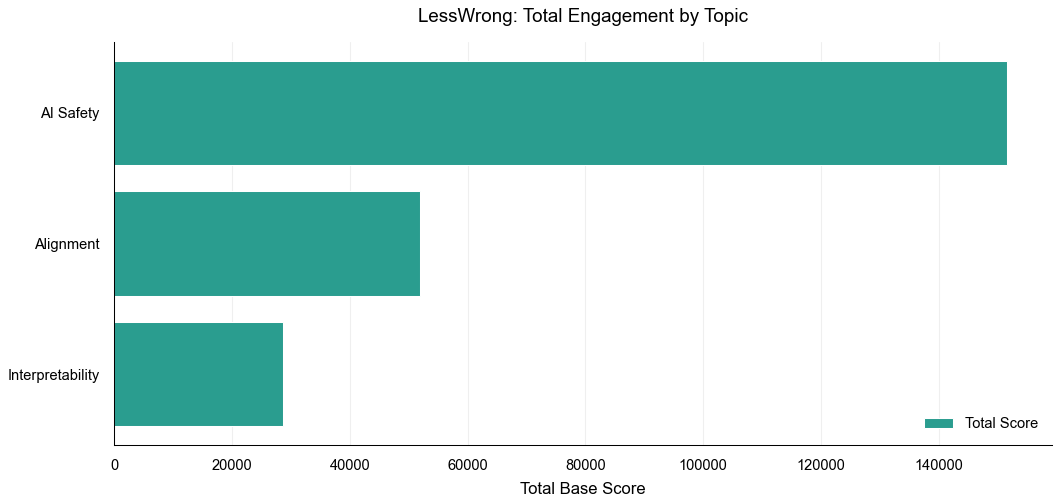

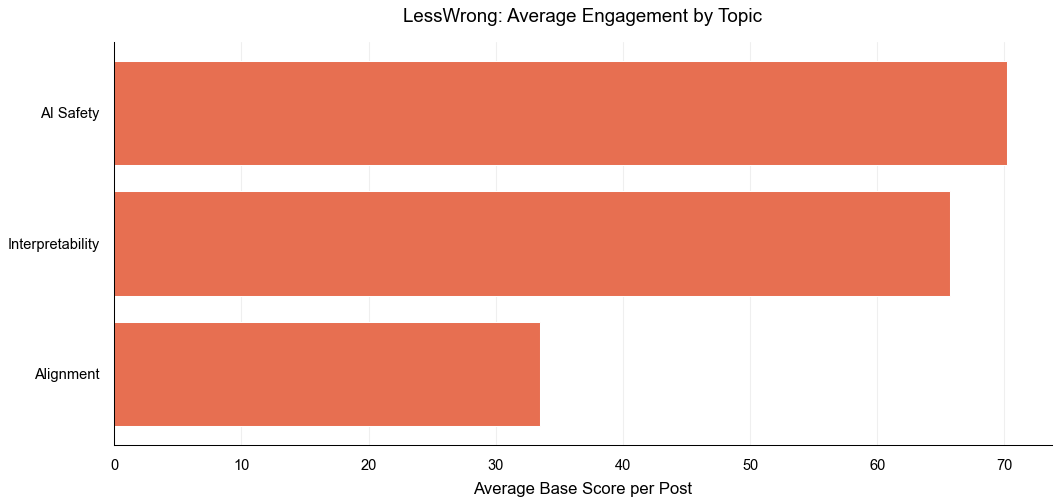

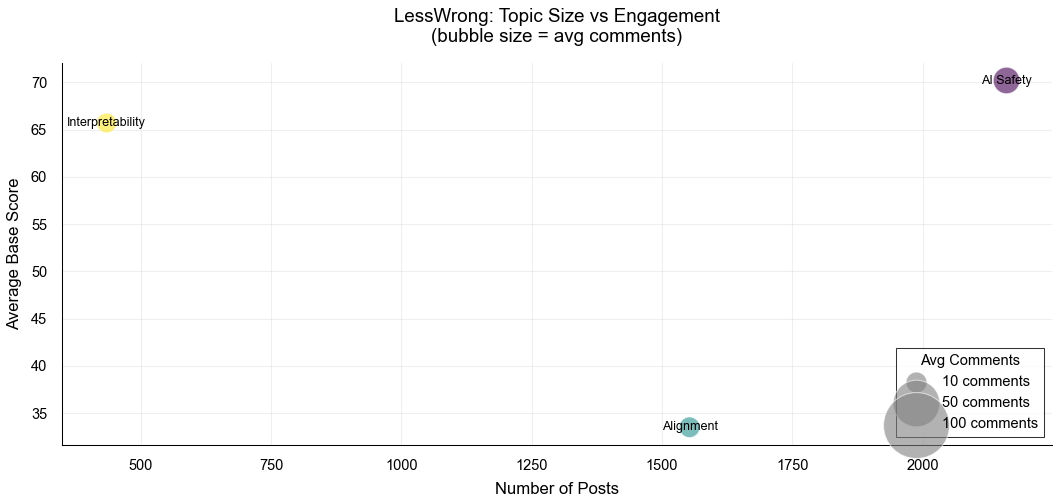

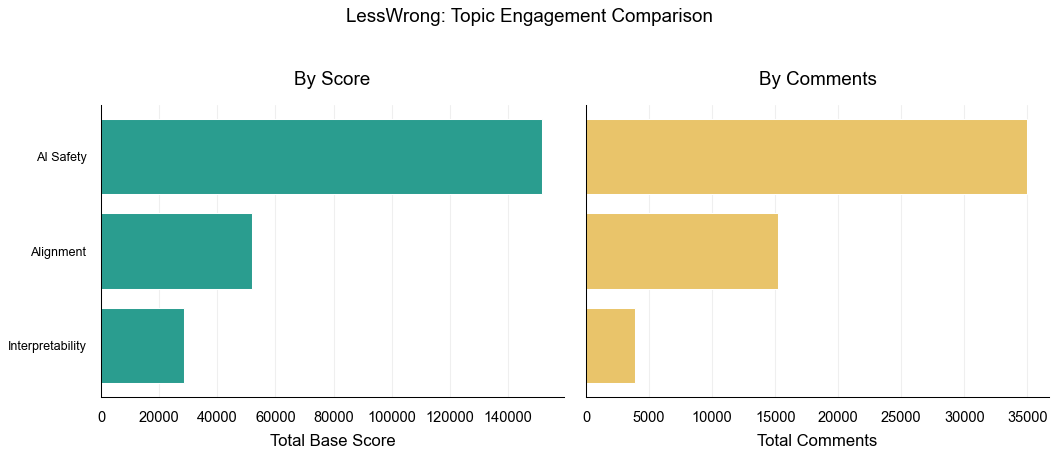


--- Alignment Forum: Topic Engagement Analysis ---

Topic Engagement Metrics:
                  baseScore_sum  baseScore_mean  baseScore_median  \
topic_label                                                         
AI Safety                151611            70.2              48.0   
Alignment                 51967            33.5              22.0   
Interpretability          28601            65.7              49.0   

                  commentCount_sum  commentCount_mean  commentCount_median  \
topic_label                                                                  
AI Safety                    34976               16.2                  7.0   
Alignment                    15214                9.8                  4.0   
Interpretability              3915                9.0                  5.0   

                  post_count  
topic_label                   
AI Safety               2161  
Alignment               1553  
Interpretability         435  


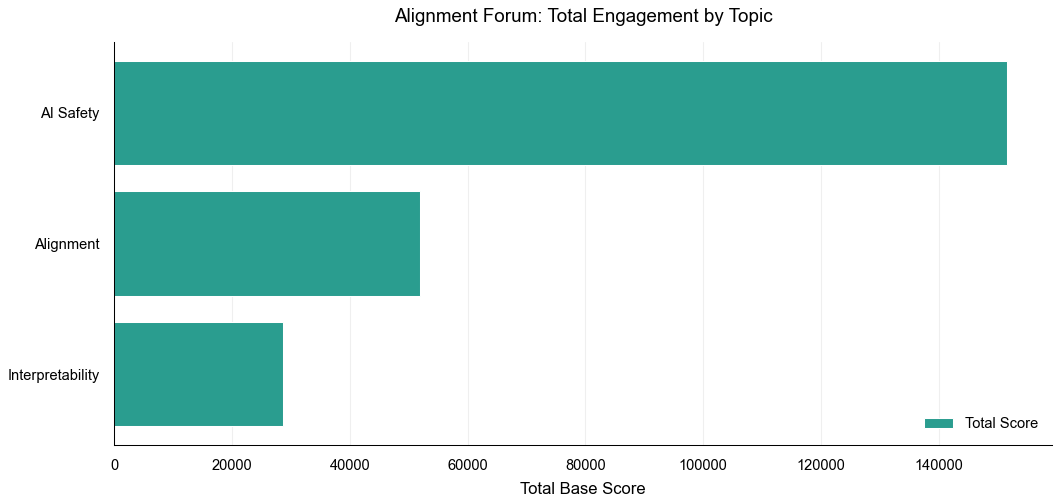

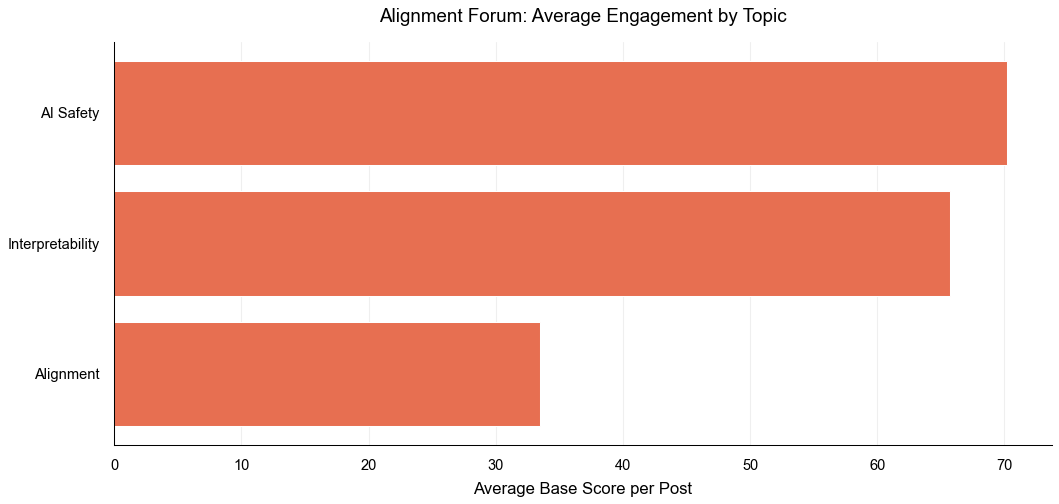

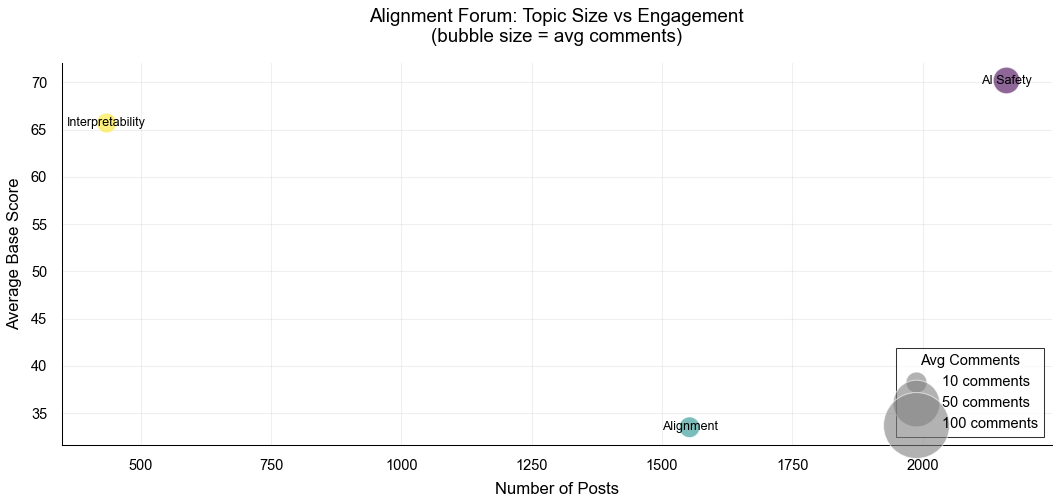

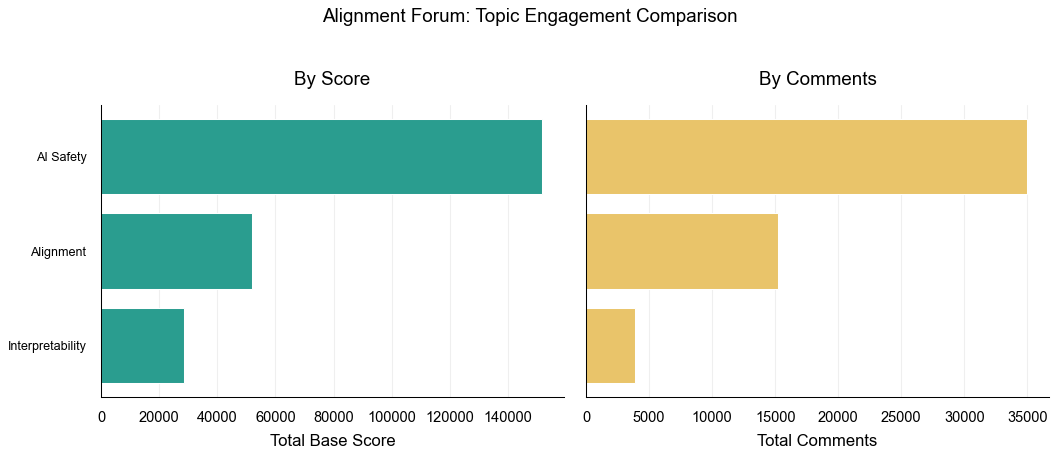


=== Topic engagement analysis complete ===


In [166]:
"""=== TOPIC ANALYSIS WITH ENGAGEMENT METRICS ==="""

# Analyze both platforms
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df)]:
    
    print(f"\n--- {platform_name}: Topic Engagement Analysis ---")
    
    safe_name = platform_name.lower().replace(" ", "_")
        
    if len(filtered_df) == 0:
        print(f"No topics found for {platform_name}")
        continue
    
    # Calculate engagement metrics by topic
    topic_engagement = filtered_df.groupby('topic_label').agg({
        'baseScore': ['sum', 'mean', 'median'],
        'commentCount': ['sum', 'mean', 'median'],
        '_id': 'count'  # Number of posts
    }).round(1)
    
    # Flatten column names
    topic_engagement.columns = ['_'.join(col).strip() for col in topic_engagement.columns.values]
    topic_engagement = topic_engagement.rename(columns={'_id_count': 'post_count'})
    
    # Sort by total score
    topic_engagement = topic_engagement.sort_values('baseScore_sum', ascending=False)
    
    print("\nTopic Engagement Metrics:")
    print(topic_engagement)
    
    # 1. Total engagement by topic (stacked bar: score + comments)
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    x_pos = np.arange(len(topic_engagement))
    
    # Normalize to make comparable (score and comments on different scales)
    # Use score as primary metric
    ax.barh(x_pos, topic_engagement['baseScore_sum'], 
            color='#2a9d8f', edgecolor='white', linewidth=0.5,
            label='Total Score')
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(topic_engagement.index)
    ax.set_xlabel('Total Base Score')
    ax.set_title(f'{platform_name}: Total Engagement by Topic', pad=10)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Average engagement per post by topic
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    x_pos = np.arange(len(topic_engagement))
    sorted_by_mean = topic_engagement.sort_values('baseScore_mean', ascending=False)
    
    ax.barh(x_pos, sorted_by_mean['baseScore_mean'], 
            color='#e76f51', edgecolor='white', linewidth=0.5)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(sorted_by_mean.index)
    ax.set_xlabel('Average Base Score per Post')
    ax.set_title(f'{platform_name}: Average Engagement by Topic', pad=10)
    ax.invert_yaxis()
    ax.grid(axis='x')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Bubble chart: Posts vs Engagement (size = comment count)
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    scatter = ax.scatter(
        topic_engagement['post_count'],
        topic_engagement['baseScore_mean'],
        s=topic_engagement['commentCount_mean'] * 10,  # Size by avg comments
        c=np.arange(len(topic_engagement)),  # Color by topic
        cmap='viridis',
        alpha=0.6,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add topic labels
    for idx, row in topic_engagement.iterrows():
        ax.annotate(idx, 
                   (row['post_count'], row['baseScore_mean']),
                   fontsize=6,
                   ha='center',
                   va='center')
    
    ax.set_xlabel('Number of Posts')
    ax.set_ylabel('Average Base Score')
    ax.set_title(f'{platform_name}: Topic Size vs Engagement\n(bubble size = avg comments)', 
                 pad=10)
    ax.grid(True, alpha=0.3)
    
    # Add legend for bubble size
    sizes = [10, 50, 100]
    labels = ['10 comments', '50 comments', '100 comments']
    legend_elements = [plt.scatter([], [], s=s*10, c='gray', alpha=0.6, 
                                   edgecolors='white', linewidth=0.5) 
                      for s in sizes]
    ax.legend(legend_elements, labels, 
             title='Avg Comments', 
             loc='lower right',
             frameon=True,
             edgecolor='black',
             fancybox=False)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 4. Engagement comparison: Score vs Comments
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(DOUBLE_COL, 3))
    
    x_pos = np.arange(len(topic_engagement))
    
    # Left: Total scores
    ax1.barh(x_pos, topic_engagement['baseScore_sum'], 
            color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(topic_engagement.index, fontsize=6)
    ax1.set_xlabel('Total Base Score')
    ax1.set_title('By Score', pad=10)
    ax1.invert_yaxis()
    ax1.grid(axis='x')
    
    # Right: Total comments
    ax2.barh(x_pos, topic_engagement['commentCount_sum'], 
            color='#e9c46a', edgecolor='white', linewidth=0.5)
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels([])  # Hide labels on right side
    ax2.set_xlabel('Total Comments')
    ax2.set_title('By Comments', pad=10)
    ax2.invert_yaxis()
    ax2.grid(axis='x')
    
    fig.suptitle(f'{platform_name}: Topic Engagement Comparison', 
                fontsize=9, y=1.02)
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== Topic engagement analysis complete ===")

## Gender Distribution


=== GENDER ANALYSIS ===

--- LessWrong ---

Gender Distribution:
Gm: 29,408 (64.8%)
-: 10,513 (23.2%)
Gf: 3,970 (8.8%)


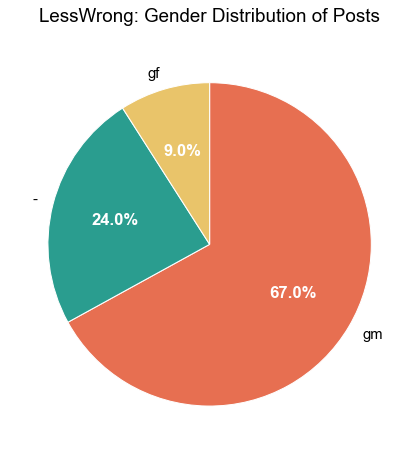


Unique Users by Gender:
Gm: 3,598 (57.9%)
-: 2,090 (33.6%)
Gf: 526 (8.5%)


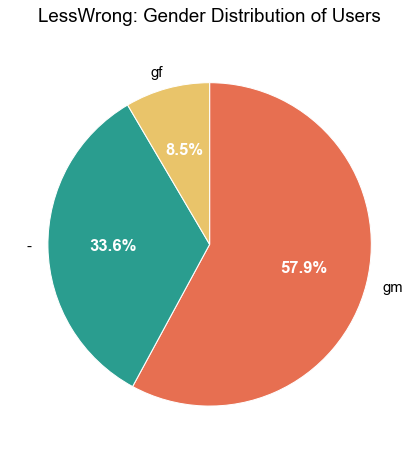

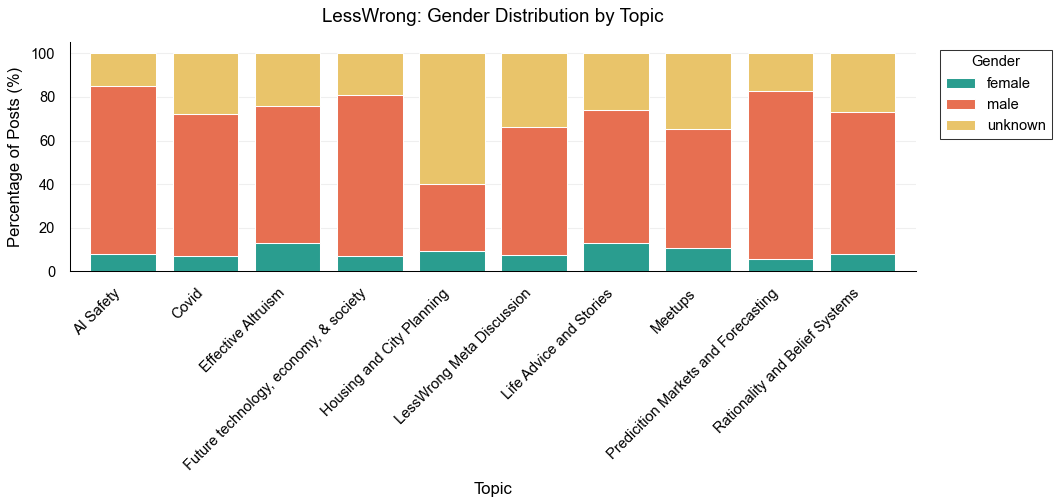


--- Alignment Forum ---

Gender Distribution:
Gm: 3,665 (86.6%)
Gf: 435 (10.3%)
-: 124 (2.9%)


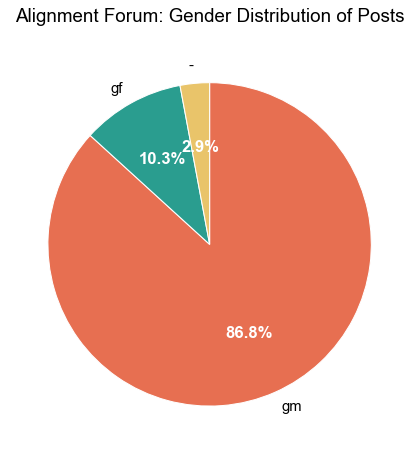


Unique Users by Gender:
Gm: 497 (79.8%)
Gf: 64 (10.3%)
-: 61 (9.8%)


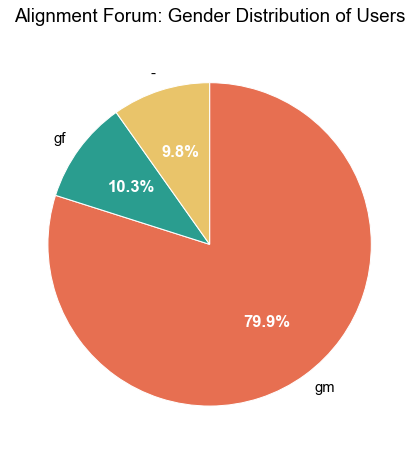

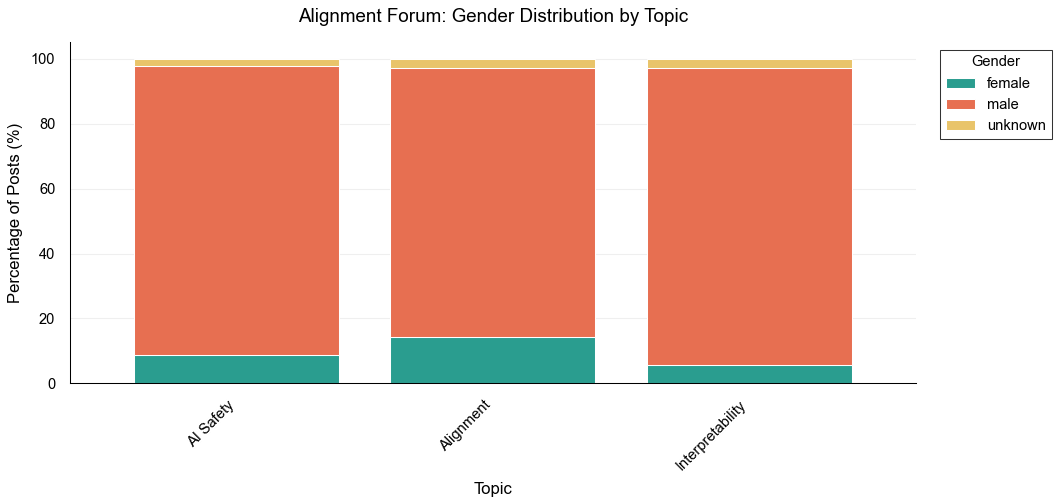


--- Combined ---

Gender Distribution:
Gm: 33,073 (66.7%)
-: 10,637 (21.5%)
Gf: 4,405 (8.9%)


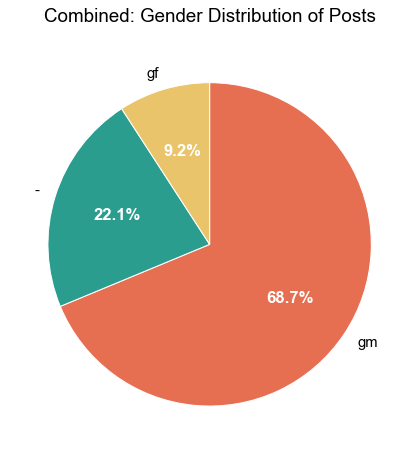


Unique Users by Gender:
Gm: 3,598 (57.9%)
-: 2,090 (33.6%)
Gf: 526 (8.5%)


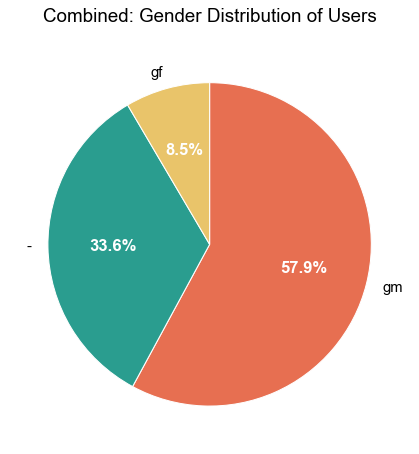

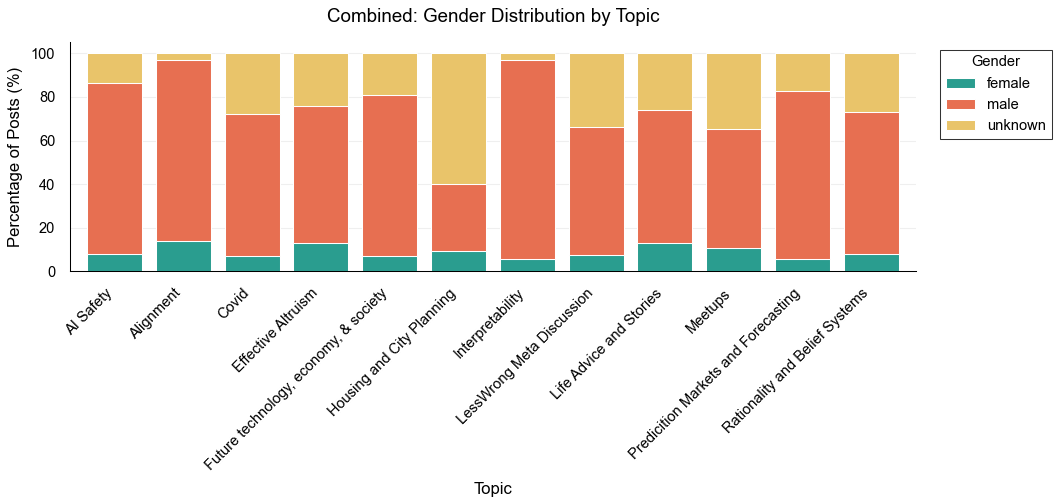


=== Gender analysis complete ===


In [157]:
"""Analyze gender distribution"""
print("\n=== GENDER ANALYSIS ===")

for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    
    print(f"\n--- {platform_name} ---")
    
    gender_counts = platform_df['user_gender'].value_counts()
    print(f"\nGender Distribution:")
    for gender, count in gender_counts.items():
        percentage = (count / len(platform_df)) * 100
        print(f"{gender.title()}: {count:,} ({percentage:.1f}%)")
    
    # Gender posts pie chart - use SINGLE_COL for pie charts
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        gender_counts.values, 
        labels=gender_counts.index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title(f'{platform_name}: Gender Distribution of Posts', pad=10)
    safe_name = platform_name.lower().replace(" ", "_")
    plt.show()
    plt.close()
    
    # Gender users pie chart
    unique_users = platform_df[['user.username', 'user_gender']].drop_duplicates()
    user_gender_counts = unique_users['user_gender'].value_counts()
    
    print(f"\nUnique Users by Gender:")
    for gender, count in user_gender_counts.items():
        percentage = (count / len(unique_users)) * 100
        print(f"{gender.title()}: {count:,} ({percentage:.1f}%)")
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        user_gender_counts.values, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        labels=user_gender_counts.index,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title(f'{platform_name}: Gender Distribution of Users', pad=10)
    plt.show()
    plt.close()
    
    # Gender distribution by topics - use DOUBLE_COL for bar charts
    filtered_df = platform_df[platform_df["topic_label"] != 'Misc: No Topic'].copy()
    
    if len(filtered_df) > 0:
        gender_topic = filtered_df.groupby(['topic_label', 'user_gender']).size().unstack(fill_value=0)
        gender_topic['total'] = gender_topic.sum(axis=1)
        
        gender_cols = {}
        if 'gf' in gender_topic.columns:
            gender_cols['female'] = 'gf'
        elif 'female' in gender_topic.columns:
            gender_cols['female'] = 'female'
            
        if 'gm' in gender_topic.columns:
            gender_cols['male'] = 'gm'
        elif 'male' in gender_topic.columns:
            gender_cols['male'] = 'male'
            
        if '-' in gender_topic.columns:
            gender_cols['unknown'] = '-'
        elif 'unknown' in gender_topic.columns:
            gender_cols['unknown'] = 'unknown'
        
        gender_perc_data = {}
        for display_name, col_name in gender_cols.items():
            if col_name in gender_topic.columns:
                gender_perc_data[display_name] = (gender_topic[col_name] * 100) / gender_topic['total']
        
        gender_perc = pd.DataFrame(gender_perc_data)
        
        fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
        gender_perc.plot(kind="bar", ax=ax,
                         color=["#2a9d8f", "#e76f51", "#e9c46a"],
                         stacked=True,
                         width=0.8,
                         edgecolor='white')
        
        ax.set_title(f'{platform_name}: Gender Distribution by Topic', pad=10)
        ax.set_ylabel('Percentage of Posts (%)')
        ax.set_xlabel('Topic')
        ax.legend(title='Gender', bbox_to_anchor=(1.02, 1), loc='upper left', 
                  frameon=True, edgecolor='black', fancybox=False)
        ax.set_xticklabels(gender_perc.index, rotation=45, ha='right')
        ax.grid(axis='y')
        
        plt.tight_layout()
        plt.show()
        plt.close()

print("\n=== Gender analysis complete ===")

## Author Analysis


=== AUTHOR ANALYSIS ===

--- LessWrong ---

Total unique authors: 6,214
Authors with only 1 post: 2,982 (48.0%)
Authors with 10+ posts: 765
Authors with 50+ posts: 149

Top 10 Most Active Authors:
  jkaufman: 1018 posts
  Zvi: 936 posts
  Stuart_Armstrong: 827 posts
  KatjaGrace: 602 posts
  MinibearRex: 590 posts
  Eliezer_Yudkowsky: 449 posts
  Raemon: 445 posts
  lukeprog: 417 posts
  johnswentworth: 356 posts
  Kaj_Sotala: 309 posts


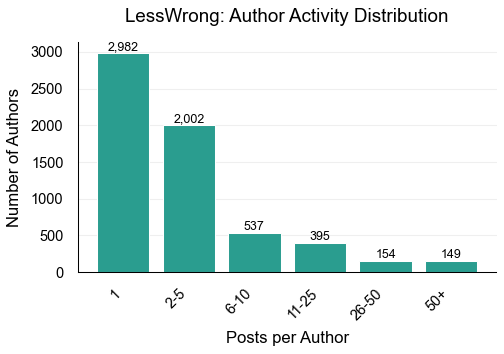

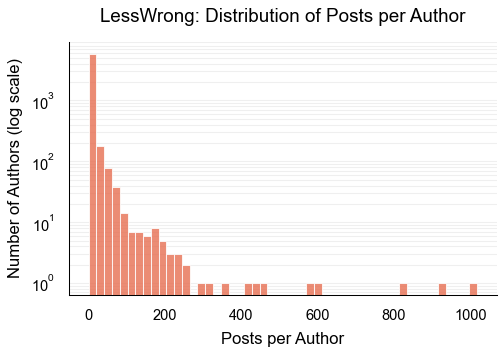


--- Alignment Forum ---

Total unique authors: 622
Authors with only 1 post: 307 (49.4%)
Authors with 10+ posts: 86
Authors with 50+ posts: 16

Top 10 Most Active Authors:
  Stuart_Armstrong: 368 posts
  rohinmshah: 206 posts
  johnswentworth: 144 posts
  abramdemski: 119 posts
  Scott Garrabrant: 101 posts
  paulfchristiano: 80 posts
  TurnTrout: 79 posts
  steve2152: 76 posts
  evhub: 70 posts
  jessica.liu.taylor: 64 posts


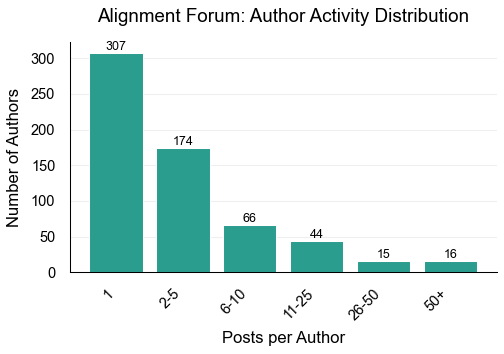

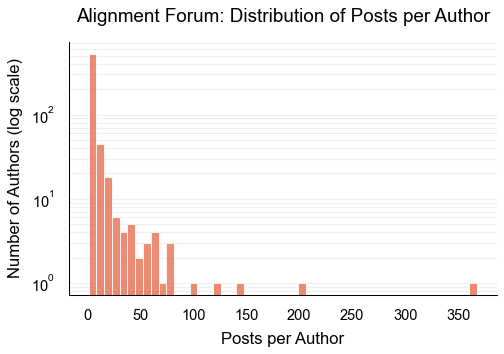


--- Combined ---

Total unique authors: 6,214
Authors with only 1 post: 2,854 (45.9%)
Authors with 10+ posts: 821
Authors with 50+ posts: 163

Top 10 Most Active Authors:
  Stuart_Armstrong: 1195 posts
  jkaufman: 1018 posts
  Zvi: 938 posts
  KatjaGrace: 607 posts
  MinibearRex: 590 posts
  johnswentworth: 500 posts
  Eliezer_Yudkowsky: 466 posts
  Raemon: 448 posts
  lukeprog: 417 posts
  rohinmshah: 414 posts


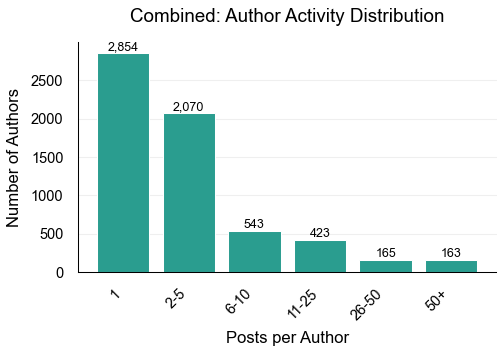

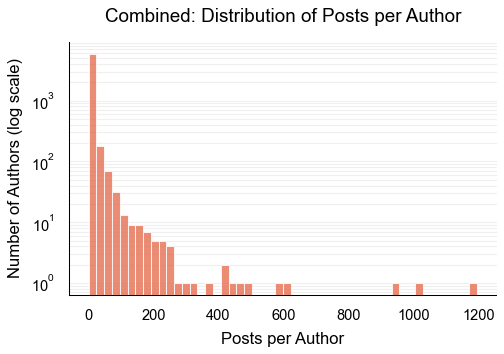


=== Author analysis complete ===


In [158]:
"""Analyze author activity patterns"""
print("\n=== AUTHOR ANALYSIS ===")

# Analyze both platforms separately and combined
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    
    print(f"\n--- {platform_name} ---")
    
    author_counts = platform_df['user.username'].value_counts()
    print(f"\nTotal unique authors: {len(author_counts):,}")
    print(f"Authors with only 1 post: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
    print(f"Authors with 10+ posts: {(author_counts >= 10).sum():,}")
    print(f"Authors with 50+ posts: {(author_counts >= 50).sum():,}")
    
    print(f"\nTop 10 Most Active Authors:")
    for author, count in author_counts.head(10).items():
        print(f"  {author}: {count} posts")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Author activity distribution (bar chart)
    post_ranges = ['1', '2-5', '6-10', '11-25', '26-50', '50+']
    counts = [
        (author_counts == 1).sum(),
        ((author_counts >= 2) & (author_counts <= 5)).sum(),
        ((author_counts >= 6) & (author_counts <= 10)).sum(),
        ((author_counts >= 11) & (author_counts <= 25)).sum(),
        ((author_counts >= 26) & (author_counts <= 50)).sum(),
        (author_counts >= 50).sum()
    ]
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 2.5))
    bars = ax.bar(post_ranges, counts, color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax.set_title(f'{platform_name}: Author Activity Distribution', pad=10)
    ax.set_ylabel('Number of Authors')
    ax.set_xlabel('Posts per Author')
    ax.set_xticklabels(post_ranges, rotation=45, ha='right')
    ax.grid(axis='y')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=6)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Posts per author histogram (log scale)
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 2.5))
    ax.hist(author_counts.values, bins=50, color='#e76f51', 
            edgecolor='white', alpha=0.8, linewidth=0.5)
    ax.set_xlabel('Posts per Author')
    ax.set_ylabel('Number of Authors (log scale)')
    ax.set_title(f'{platform_name}: Distribution of Posts per Author', pad=10)
    ax.set_yscale('log')
    ax.grid(axis='y', which='both')  # Show grid for both major and minor ticks on log scale
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== Author analysis complete ===")

## Temporal Trends


=== TEMPORAL TRENDS ===

--- LessWrong ---

Posts by Year:
  2009: 861 posts
  2010: 1,163 posts
  2011: 3,028 posts
  2012: 2,657 posts
  2013: 2,020 posts
  2014: 1,820 posts
  2015: 2,022 posts
  2016: 1,316 posts
  2017: 1,674 posts
  2018: 1,842 posts
  2019: 2,335 posts
  2020: 3,113 posts
  2021: 3,474 posts
  2022: 4,736 posts
  2023: 5,662 posts
  2024: 4,637 posts
  2025: 2,997 posts


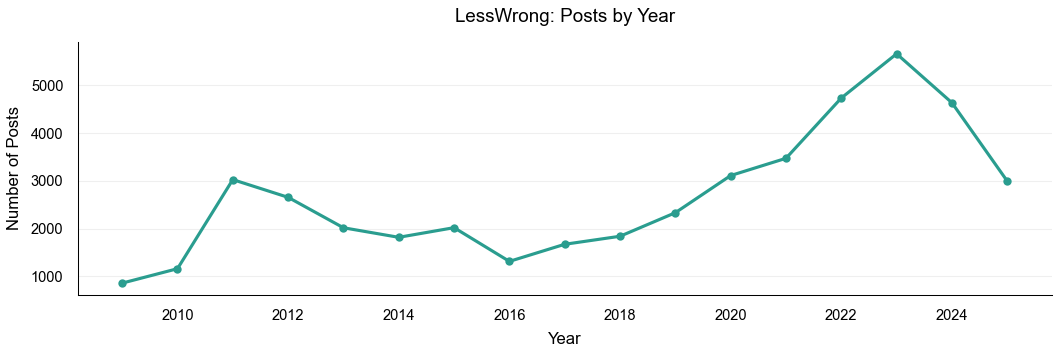

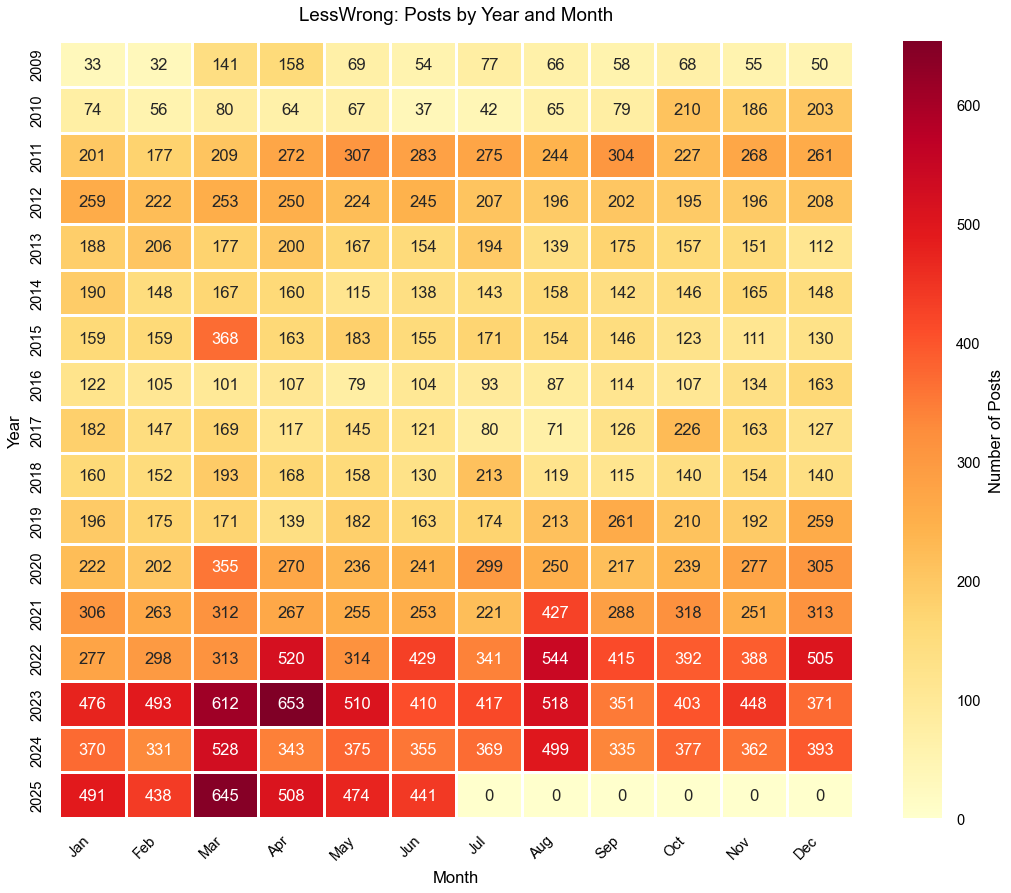

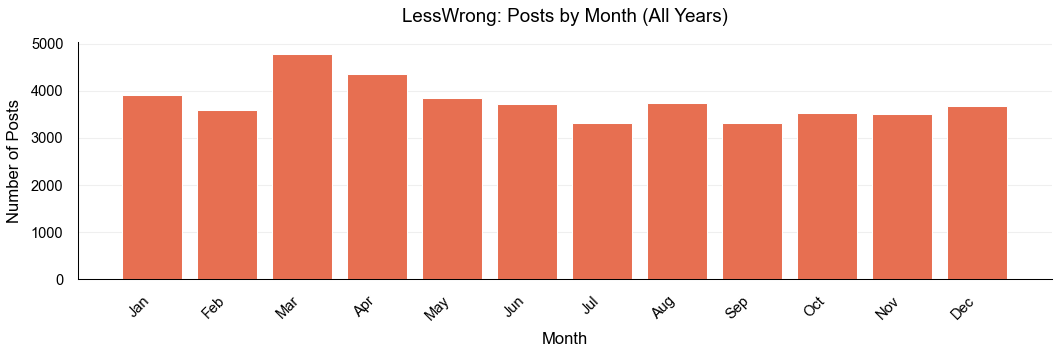


--- Alignment Forum ---

Posts by Year:
  2015: 161 posts
  2016: 122 posts
  2017: 167 posts
  2018: 258 posts
  2019: 372 posts
  2020: 443 posts
  2021: 528 posts
  2022: 707 posts
  2023: 736 posts
  2024: 426 posts
  2025: 310 posts


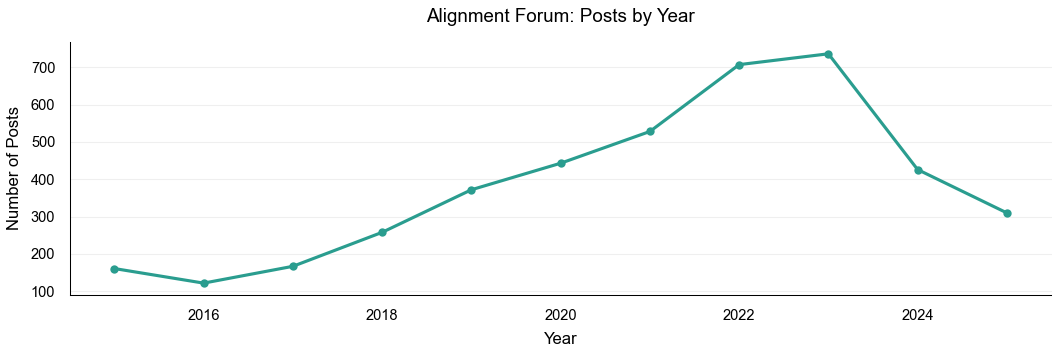

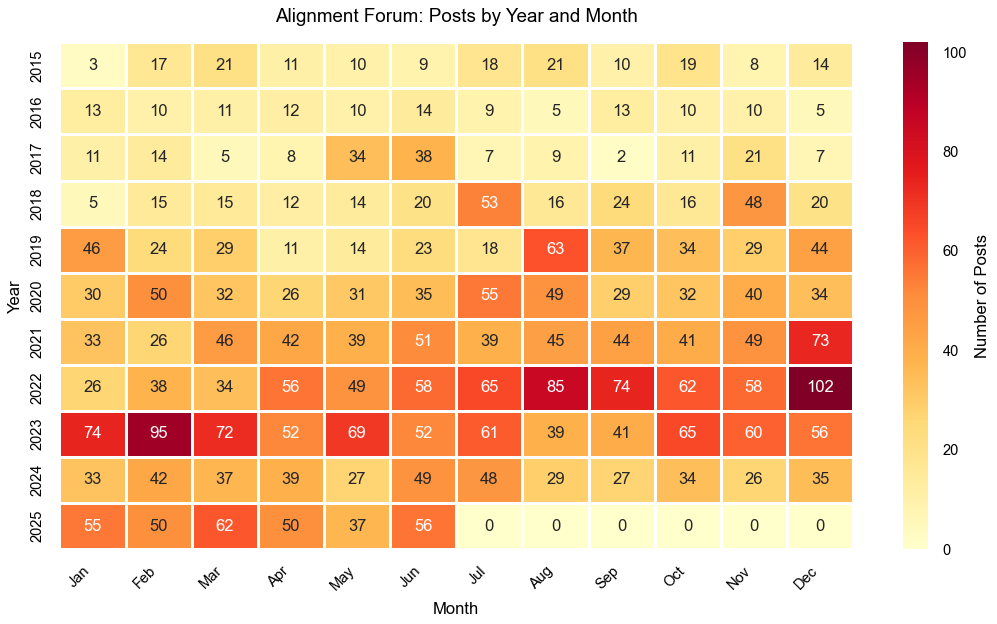

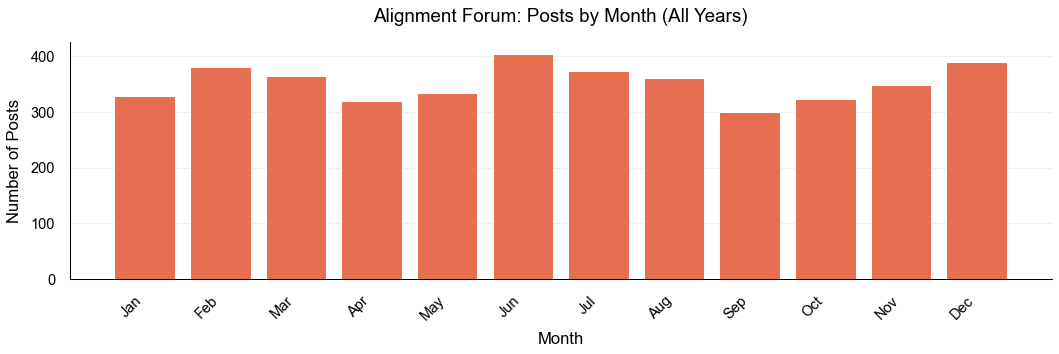


--- Combined ---

Posts by Year:
  2009: 861 posts
  2010: 1,163 posts
  2011: 3,028 posts
  2012: 2,657 posts
  2013: 2,020 posts
  2014: 1,820 posts
  2015: 2,183 posts
  2016: 1,438 posts
  2017: 1,841 posts
  2018: 2,100 posts
  2019: 2,707 posts
  2020: 3,556 posts
  2021: 4,002 posts
  2022: 5,443 posts
  2023: 6,398 posts
  2024: 5,063 posts
  2025: 3,307 posts


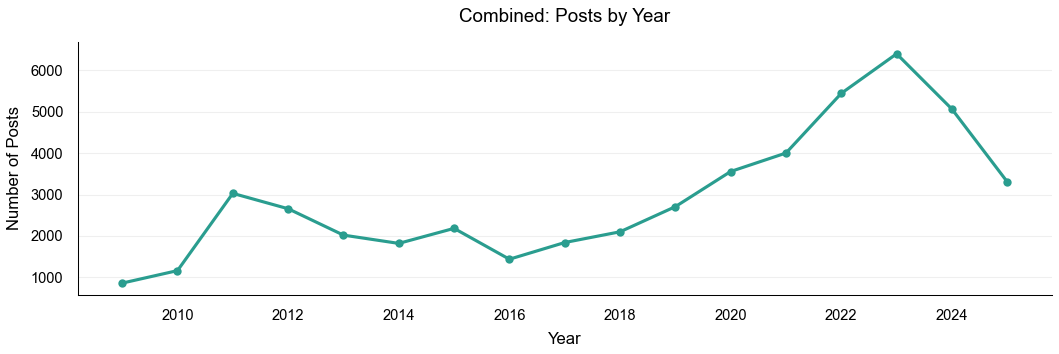

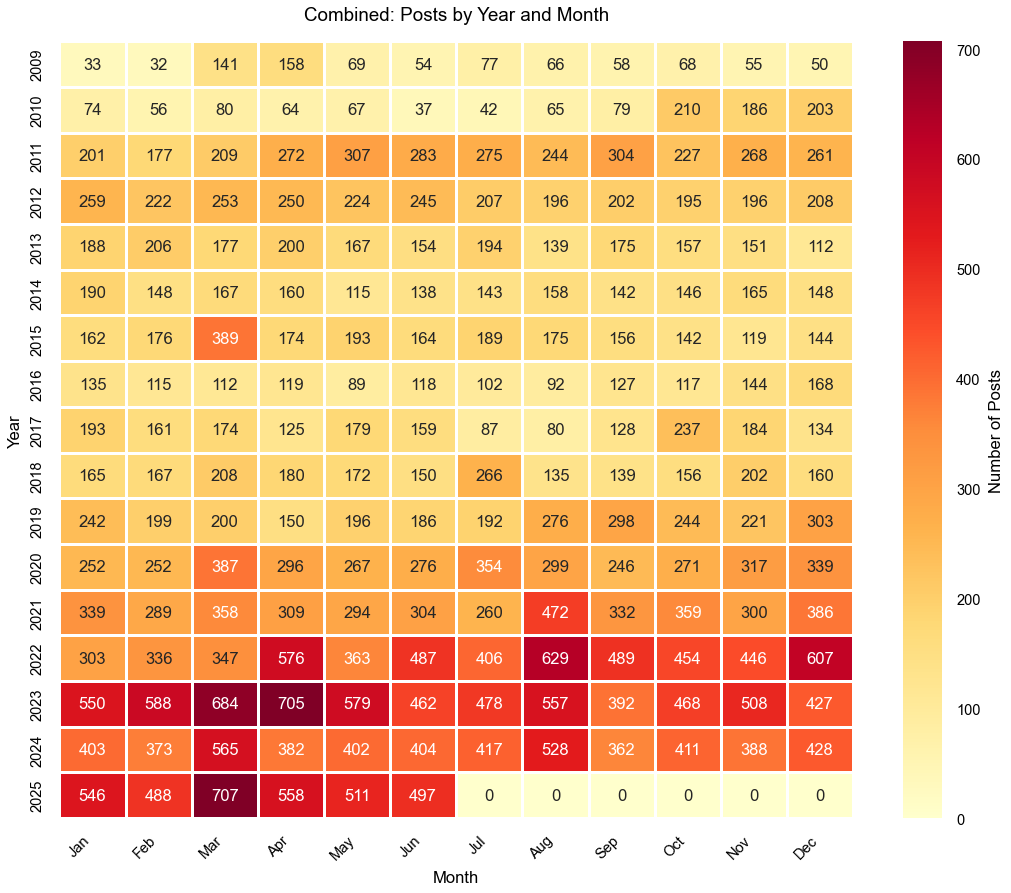

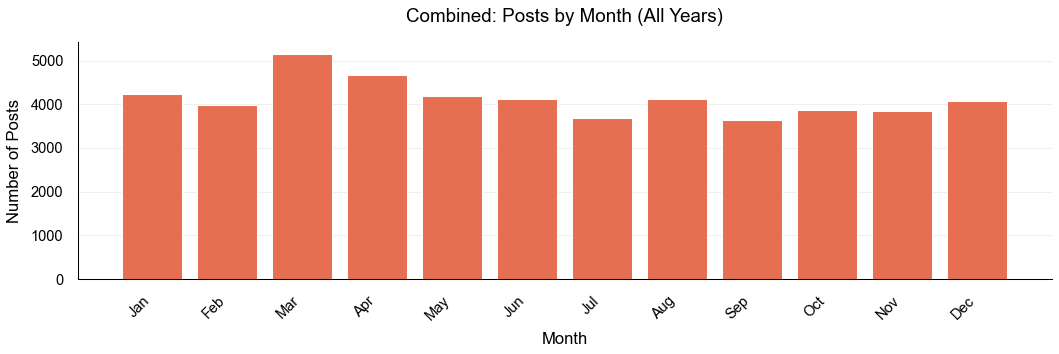


=== Temporal trends analysis complete ===


In [160]:
"""Analyze temporal trends"""
print("\n=== TEMPORAL TRENDS ===")

import seaborn as sns

# Analyze both platforms separately and combined
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    
    print(f"\n--- {platform_name} ---")
    
    # Posts by year
    yearly_posts = platform_df.groupby('year').size()
    print(f"\nPosts by Year:")
    for year, count in yearly_posts.items():
        print(f"  {year}: {count:,} posts")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Line plot of posts over time
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 2.5))
    ax.plot(yearly_posts.index, yearly_posts.values, 
            marker='o', linewidth=1.5, markersize=4, 
            color='#2a9d8f')
    ax.set_title(f'{platform_name}: Posts by Year', pad=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Posts')
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Heatmap of posts by year and month
    if 'month' in platform_df.columns:
        heatmap_data = platform_df.groupby(['year', 'month']).size().unstack(fill_value=0)
        
        # Ensure all months 1-12 are present
        for month in range(1, 13):
            if month not in heatmap_data.columns:
                heatmap_data[month] = 0
        heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
        
        fig, ax = plt.subplots(figsize=(DOUBLE_COL, len(heatmap_data) * 0.3 + 1))
        
        # Use Nature-appropriate colormap
        sns.heatmap(heatmap_data, annot=True, fmt='d', 
                    cmap='YlOrRd', 
                    ax=ax,
                    cbar_kws={'label': 'Number of Posts'},
                    linewidths=0.5,
                    linecolor='white')
        
        ax.set_title(f'{platform_name}: Posts by Year and Month', pad=10)
        ax.set_xlabel('Month')
        ax.set_ylabel('Year')
        
        # Set month labels
        month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax.set_xticklabels(month_labels, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        plt.close()
    
    # Monthly activity (aggregated across all years)
    if 'month' in platform_df.columns:
        monthly_posts = platform_df.groupby('month').size()
        
        fig, ax = plt.subplots(figsize=(DOUBLE_COL, 2.5))
        bars = ax.bar(monthly_posts.index, monthly_posts.values, 
                      color='#e76f51', edgecolor='white', linewidth=0.5)
        ax.set_title(f'{platform_name}: Posts by Month (All Years)', pad=10)
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Posts')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                          rotation=45, ha='right')
        ax.grid(axis='y')
        
        plt.tight_layout()
        plt.show()
        plt.close()

print("\n=== Temporal trends analysis complete ===")

## Links


=== LINK ANALYSIS ===

--- LessWrong ---
Total links extracted: 380,744
Posts with links: 29,342

=== LINK CATEGORIES ===
DOI/Academic: 5,471 (1.4%)
ArXiv: 17,782 (4.7%)
LessWrong: 88,151 (23.2%)
YouTube: 7,082 (1.9%)
Wikipedia: 28,879 (7.6%)
GitHub: 4,808 (1.3%)

=== TOP 15 DOMAINS ===
  lesswrong.com: 72,268 (19.0%)
  en.wikipedia.org: 28,254 (7.4%)
  arxiv.org: 17,731 (4.7%)
  twitter.com: 17,363 (4.6%)
  wiki.lesswrong.com: 14,517 (3.8%)
  x.com: 9,701 (2.5%)
  alignmentforum.org: 8,333 (2.2%)
  substackcdn.com: 6,556 (1.7%)
  youtube.com: 5,913 (1.6%)
  forum.effectivealtruism.org: 5,748 (1.5%)
  thezvi.substack.com: 4,633 (1.2%)
  docs.google.com: 4,208 (1.1%)
  jefftk.com: 3,554 (0.9%)
  amazon.com: 3,157 (0.8%)
  github.com: 2,886 (0.8%)


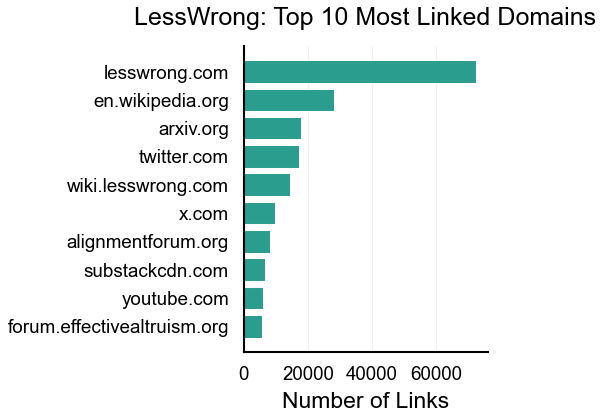

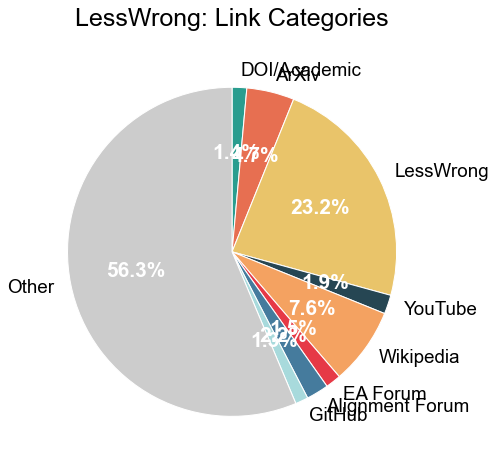

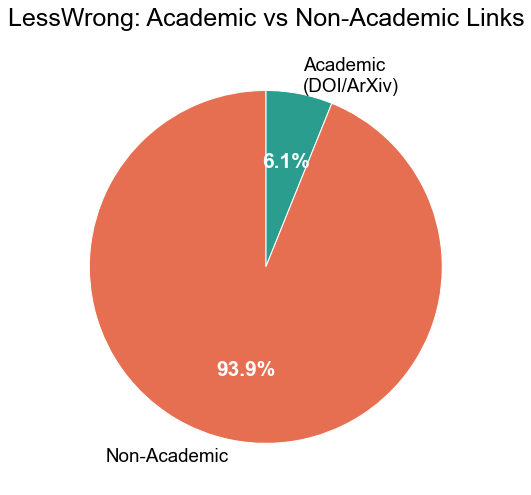


=== SAMPLE LINKS ===
Sample DOI links: ['http://link.springer.com/article/10.1007/s11238-006-9004-4', 'http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476620']
Sample ArXiv links: ['http://arxiv.org/pdf/hep-ph/9910333.pdf', 'http://arxiv.org/pdf/1306.0159v2.pdf']
Sample LessWrong links: ['https://lesswrong.com/meetups/rp', 'https://lesswrong.com/meetups/ro']

--- Alignment Forum ---
Total links extracted: 64,307
Posts with links: 3,619

=== LINK CATEGORIES ===
DOI/Academic: 754 (1.2%)
ArXiv: 10,112 (15.7%)
LessWrong: 14,410 (22.4%)
YouTube: 798 (1.2%)
Wikipedia: 3,770 (5.9%)
GitHub: 1,583 (2.5%)

=== TOP 15 DOMAINS ===
  lesswrong.com: 14,293 (22.2%)
  arxiv.org: 10,101 (15.7%)
  alignmentforum.org: 6,946 (10.8%)
  en.wikipedia.org: 3,744 (5.8%)
  docs.google.com: 1,280 (2.0%)
  github.com: 930 (1.4%)
  mailchi.mp: 886 (1.4%)
  intelligence.org: 872 (1.4%)
  transformer-circuits.pub: 730 (1.1%)
  agentfoundations.org: 714 (1.1%)
  ai-alignment.com: 699 (1.1%)
  youtube.com:

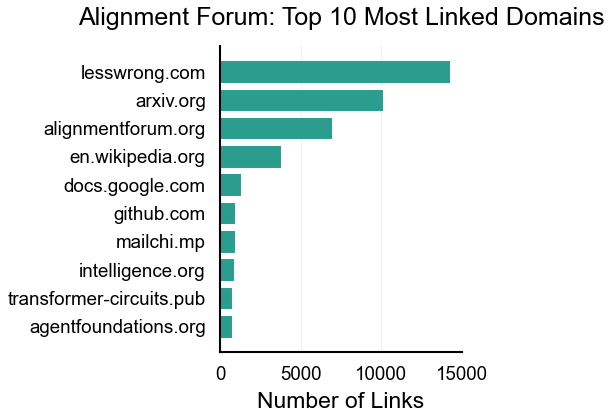

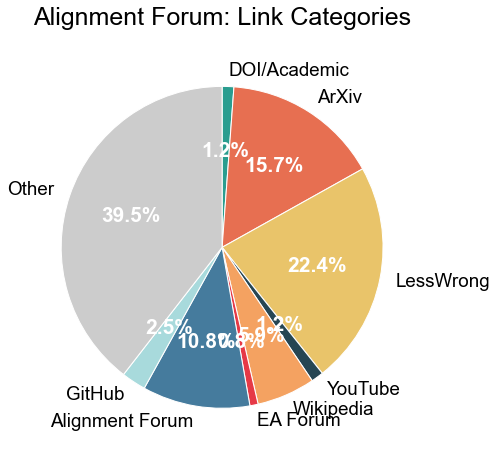

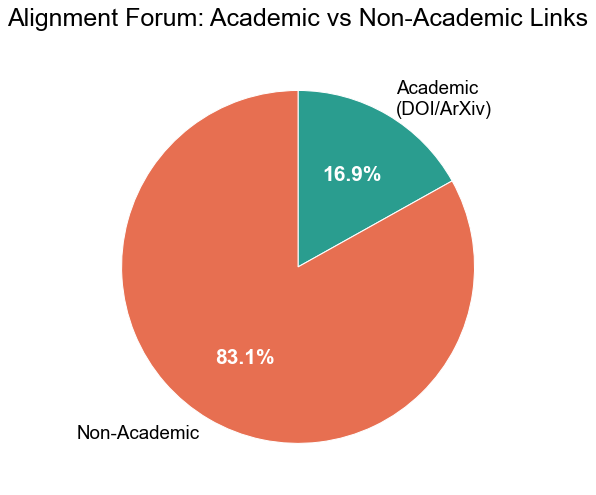


=== SAMPLE LINKS ===
Sample DOI links: ['https://doi.org/10.1038/s42256-019-0048-x', 'https://link.springer.com/article/10.1007/s12685-013-0088-9']
Sample ArXiv links: ['https://arxiv.org/abs/2201.08239', 'https://arxiv.org/abs/2206.14858']
Sample LessWrong links: ['https://www.lesswrong.com/s/n945eovrA3oDueqtq', 'https://www.lesswrong.com/posts/ADMWDDKGgivgghxWf/productive-mistakes-not-perfect-answers']

--- Combined ---
Total links extracted: 445,051
Posts with links: 32,961

=== LINK CATEGORIES ===
DOI/Academic: 6,225 (1.4%)
ArXiv: 27,894 (6.3%)
LessWrong: 102,561 (23.0%)
YouTube: 7,880 (1.8%)
Wikipedia: 32,649 (7.3%)
GitHub: 6,391 (1.4%)

=== TOP 15 DOMAINS ===
  lesswrong.com: 86,561 (19.4%)
  en.wikipedia.org: 31,998 (7.2%)
  arxiv.org: 27,832 (6.3%)
  twitter.com: 17,770 (4.0%)
  alignmentforum.org: 15,279 (3.4%)
  wiki.lesswrong.com: 14,621 (3.3%)
  x.com: 9,876 (2.2%)
  substackcdn.com: 6,590 (1.5%)
  youtube.com: 6,562 (1.5%)
  forum.effectivealtruism.org: 6,278 (1.4%)
  doc

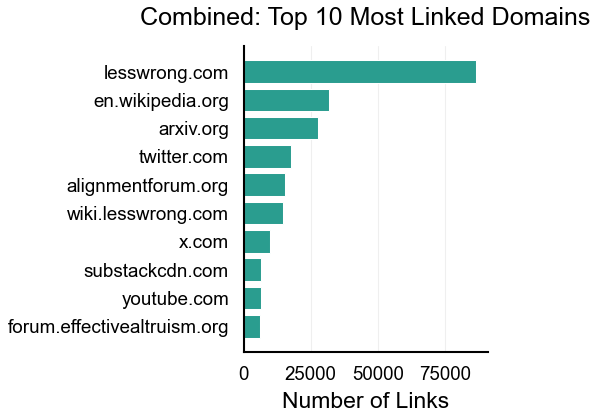

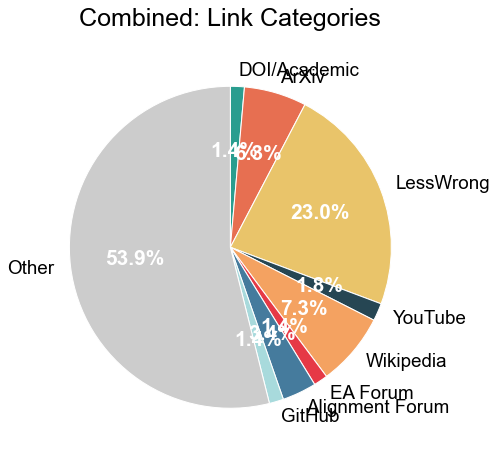

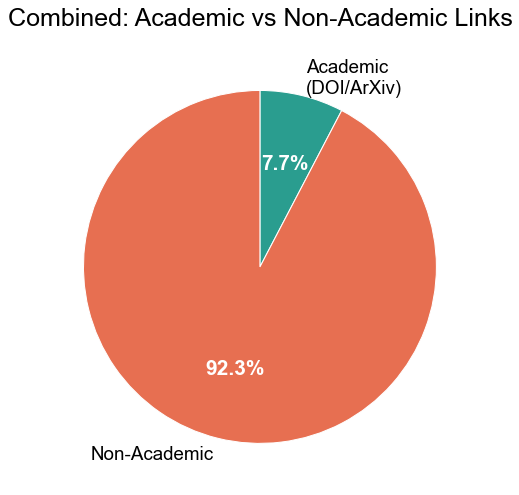


=== SAMPLE LINKS ===
Sample DOI links: ['http://link.springer.com/article/10.1007/s11238-006-9004-4', 'http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476620']
Sample ArXiv links: ['http://arxiv.org/pdf/hep-ph/9910333.pdf', 'http://arxiv.org/pdf/1306.0159v2.pdf']
Sample LessWrong links: ['https://lesswrong.com/meetups/rp', 'https://lesswrong.com/meetups/ro']

=== Link analysis complete ===


In [218]:
"""Analyze extracted links"""
print("\n=== LINK ANALYSIS ===")

import re
from urllib.parse import urlparse

def extract_domain(url):
    """Extract domain from URL."""
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Remove www. prefix for cleaner grouping
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'invalid_url'

def analyze_links(platform_df, platform_name):
    """Analyze links for a given platform."""
    print(f"\n--- {platform_name} ---")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Extract all links
    all_links = []
    for entry in platform_df['extracted_links'].dropna():
        if isinstance(entry, str):
            links = [link.strip() for link in entry.split(';') if link.strip()]
            all_links.extend(links)
        elif isinstance(entry, list):
            all_links.extend(entry)
        else:
            links = [link.strip() for link in str(entry).split(';') if link.strip()]
            all_links.extend(links)
    
    # Final cleaning
    clean_links = [l for l in all_links if l]
    
    if not clean_links:
        print(f"No links found for {platform_name}")
        return
    
    print(f"Total links extracted: {len(clean_links):,}")
    print(f"Posts with links: {platform_df['extracted_links'].notna().sum():,}")
    
    # Pattern analysis
    doi_pattern = r'10\.\d{4,9}/[^\s;<>"]+'
    arxiv_pattern = r'(arxiv\.org/)'
    
    doi_links = [link for link in clean_links if re.search(doi_pattern, link, re.IGNORECASE)]
    arxiv_links = [link for link in clean_links if re.search(arxiv_pattern, link, re.IGNORECASE)]
    lesswrong_links = [link for link in clean_links if 'lesswrong' in link.lower()]
    
    # Extract domains
    domains = [extract_domain(link) for link in clean_links]
    domain_counts = pd.Series(domains).value_counts()
    
    # Category counts
    youtube_count = len([d for d in domains if 'youtube' in d or 'youtu.be' in d])
    wikipedia_count = len([d for d in domains if 'wikipedia' in d])
    github_count = len([d for d in domains if 'github' in d])
    ea_forum_count = len([d for d in domains if 'forum.effectivealtruism' in d])
    alignment_forum_count = len([d for d in domains if 'alignmentforum' in d])
    
    print(f"\n=== LINK CATEGORIES ===")
    print(f"DOI/Academic: {len(doi_links):,} ({len(doi_links)/len(clean_links)*100:.1f}%)")
    print(f"ArXiv: {len(arxiv_links):,} ({len(arxiv_links)/len(clean_links)*100:.1f}%)")
    print(f"LessWrong: {len(lesswrong_links):,} ({len(lesswrong_links)/len(clean_links)*100:.1f}%)")
    print(f"YouTube: {youtube_count:,} ({youtube_count/len(clean_links)*100:.1f}%)")
    print(f"Wikipedia: {wikipedia_count:,} ({wikipedia_count/len(clean_links)*100:.1f}%)")
    print(f"GitHub: {github_count:,} ({github_count/len(clean_links)*100:.1f}%)")
    
    print(f"\n=== TOP 15 DOMAINS ===")
    for domain, count in domain_counts.head(15).items():
        percentage = count/len(clean_links)*100
        print(f"  {domain}: {count:,} ({percentage:.1f}%)")
    
    # Visualizations
    
    # 1. Top domains bar chart
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 3))
    top_domains = domain_counts.head(10)
    bars = ax.barh(range(len(top_domains)), top_domains.values, 
                   color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax.set_yticks(range(len(top_domains)))
    ax.set_yticklabels(top_domains.index)
    ax.set_xlabel('Number of Links')
    ax.set_title(f'{platform_name}: Top 10 Most Linked Domains', pad=10)
    ax.invert_yaxis()
    ax.grid(axis='x')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Link categories pie chart
    categories = {
        'DOI/Academic': len(doi_links),
        'ArXiv': len(arxiv_links),
        'LessWrong': len(lesswrong_links),
        'YouTube': youtube_count,
        'Wikipedia': wikipedia_count,
        'EA Forum': ea_forum_count,
        'Alignment Forum': alignment_forum_count,
        'GitHub': github_count,
    }
    
    # Calculate "Other" category
    other_count = len(clean_links) - sum(categories.values())
    if other_count > 0:
        categories['Other'] = other_count
    
    # Filter out zero-count categories
    categories = {k: v for k, v in categories.items() if v > 0}
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        categories.values(), 
        labels=categories.keys(), 
        autopct='%1.1f%%', 
        startangle=90,
        colors=['#2a9d8f', '#e76f51', '#e9c46a', '#264653', '#f4a261', 
                '#e63946', '#457b9d', '#a8dadc', '#cccccc'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title(f'{platform_name}: Link Categories', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Academic vs Non-Academic
    academic_count = len(doi_links) + len(arxiv_links)
    non_academic_count = len(clean_links) - academic_count
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        [academic_count, non_academic_count],
        labels=['Academic\n(DOI/ArXiv)', 'Non-Academic'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2a9d8f', '#e76f51'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title(f'{platform_name}: Academic vs Non-Academic Links', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Sample links for verification
    print(f"\n=== SAMPLE LINKS ===")
    if doi_links:
        print(f"Sample DOI links: {doi_links[:2]}")
    if arxiv_links:
        print(f"Sample ArXiv links: {arxiv_links[:2]}")
    if lesswrong_links:
        print(f"Sample LessWrong links: {lesswrong_links[:2]}")

# Run analysis for each platform
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    if 'extracted_links' in platform_df.columns:
        analyze_links(platform_df, platform_name)
    else:
        print(f"\n--- {platform_name} ---")
        print("No 'extracted_links' column found")

print("\n=== Link analysis complete ===")

## Summary

In [163]:
"""Generate comprehensive summary reports"""

def generate_summary_report(platform_df, platform_name):
    """Generate a detailed summary report for a platform."""
    
    print("\n" + "="*70)
    print(f"          {platform_name.upper()} DATA SUMMARY REPORT")
    print("="*70)
    
    # Overall Statistics
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   Total Posts: {len(platform_df):,}")
    print(f"   Date Range: {platform_df['year'].min()}-{platform_df['year'].max()}")
    print(f"   Unique Authors: {platform_df['user.username'].nunique():,}")
    if 'topic_label' in platform_df.columns:
        unique_topics = platform_df[platform_df['topic_label'] != 'Misc: No Topic']['topic_label'].nunique()
        print(f"   Unique Topics: {unique_topics}")
    
    # Author Insights
    print(f"\n👥 AUTHOR INSIGHTS:")
    author_counts = platform_df['user.username'].value_counts()
    print(f"   One-time contributors: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
    print(f"   Regular authors (2-9 posts): {((author_counts >= 2) & (author_counts < 10)).sum():,}")
    print(f"   Prolific authors (10-49 posts): {((author_counts >= 10) & (author_counts < 50)).sum():,}")
    print(f"   Super authors (50+ posts): {(author_counts >= 50).sum():,}")
    print(f"   Most prolific: {author_counts.index[0]} with {author_counts.iloc[0]:,} posts")
    
    # Show top 5 authors
    print(f"   Top 5 authors:")
    for i, (author, count) in enumerate(author_counts.head(5).items(), 1):
        print(f"      {i}. {author}: {count:,} posts")
    
    # Topic Insights
    if 'topic_label' in platform_df.columns:
        print(f"\n🏷️  TOPIC INSIGHTS:")
        topic_df = platform_df[platform_df['topic_label'] != 'Misc: No Topic']
        topic_counts = topic_df['topic_label'].value_counts()
        if len(topic_counts) > 0:
            print(f"   Most popular topic: {topic_counts.index[0]} ({topic_counts.iloc[0]:,} posts, {topic_counts.iloc[0]/len(topic_df)*100:.1f}%)")
            print(f"   Topics with 100+ posts: {(topic_counts >= 100).sum()}")
            print(f"   Topics with 1000+ posts: {(topic_counts >= 1000).sum()}")
            print(f"   Topic distribution:")
            for topic, count in topic_counts.items():
                percentage = (count / len(topic_df)) * 100
                print(f"      {topic}: {count:,} ({percentage:.1f}%)")
    
    # Gender Distribution
    print(f"\n🚻 GENDER DISTRIBUTION:")
    if 'user_gender' in platform_df.columns:
        gender_counts = platform_df['user_gender'].value_counts()
        for gender, count in gender_counts.items():
            percentage = (count / len(platform_df)) * 100
            print(f"   {gender.title()}: {count:,} ({percentage:.1f}%)")
        
        # Unique users by gender
        unique_users = platform_df[['user.username', 'user_gender']].drop_duplicates()
        user_gender_counts = unique_users['user_gender'].value_counts()
        print(f"   Unique users by gender:")
        for gender, count in user_gender_counts.items():
            percentage = (count / len(unique_users)) * 100
            print(f"      {gender.title()}: {count:,} ({percentage:.1f}%)")
    
    # Engagement Metrics
    print(f"\n📈 ENGAGEMENT METRICS:")
    print(f"   Average score: {platform_df['baseScore'].mean():.1f}")
    print(f"   Median score: {platform_df['baseScore'].median():.1f}")
    print(f"   Average comments: {platform_df['commentCount'].mean():.1f}")
    print(f"   Median comments: {platform_df['commentCount'].median():.1f}")
    print(f"   Total comments: {platform_df['commentCount'].sum():,}")
    
    # Top posts
    top_score_idx = platform_df['baseScore'].idxmax()
    top_comments_idx = platform_df['commentCount'].idxmax()
    print(f"   Highest scoring post ({platform_df.loc[top_score_idx, 'baseScore']:.0f} points):")
    print(f"      '{platform_df.loc[top_score_idx, 'title'][:60]}...'")
    print(f"      by {platform_df.loc[top_score_idx, 'user.username']}")
    print(f"   Most commented post ({platform_df.loc[top_comments_idx, 'commentCount']:.0f} comments):")
    print(f"      '{platform_df.loc[top_comments_idx, 'title'][:60]}...'")
    print(f"      by {platform_df.loc[top_comments_idx, 'user.username']}")
    
    # Score and comment distribution
    high_score = (platform_df['baseScore'] >= 100).sum()
    very_high_score = (platform_df['baseScore'] >= 500).sum()
    print(f"   Posts with 100+ score: {high_score:,} ({high_score/len(platform_df)*100:.1f}%)")
    print(f"   Posts with 500+ score: {very_high_score:,} ({very_high_score/len(platform_df)*100:.1f}%)")
    
    # Temporal Trends
    print(f"\n📅 TEMPORAL TRENDS:")
    yearly_posts = platform_df.groupby('year').size()
    peak_year = yearly_posts.idxmax()
    print(f"   Peak posting year: {peak_year} with {yearly_posts[peak_year]:,} posts")
    if len(yearly_posts) > 1:
        growth = ((yearly_posts.iloc[-1] / yearly_posts.iloc[0] - 1) * 100)
        print(f"   Growth from {yearly_posts.index[0]} to {yearly_posts.index[-1]}: {growth:+.1f}%")
    
    # Year-by-year breakdown
    print(f"   Posts by year:")
    for year, count in yearly_posts.items():
        print(f"      {year}: {count:,} posts")
    
    # Monthly patterns (if available)
    if 'month' in platform_df.columns:
        monthly_posts = platform_df.groupby('month').size()
        peak_month = monthly_posts.idxmax()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        print(f"   Most active month: {month_names[peak_month-1]} ({monthly_posts[peak_month]:,} posts total)")
    
    # Link Analysis (if available)
    if 'extracted_links' in platform_df.columns:
        print(f"\n🔗 LINK ANALYSIS:")
        posts_with_links = platform_df['extracted_links'].notna().sum()
        print(f"   Posts with links: {posts_with_links:,} ({posts_with_links/len(platform_df)*100:.1f}%)")
        print(f"   Posts without links: {len(platform_df) - posts_with_links:,} ({(len(platform_df) - posts_with_links)/len(platform_df)*100:.1f}%)")
    
    # Word count analysis (if available)
    if 'wordCount' in platform_df.columns:
        print(f"\n📝 CONTENT METRICS:")
        print(f"   Average word count: {platform_df['wordCount'].mean():.0f}")
        print(f"   Median word count: {platform_df['wordCount'].median():.0f}")
        short_posts = (platform_df['wordCount'] < 500).sum()
        medium_posts = ((platform_df['wordCount'] >= 500) & (platform_df['wordCount'] < 2000)).sum()
        long_posts = (platform_df['wordCount'] >= 2000).sum()
        print(f"   Short posts (<500 words): {short_posts:,} ({short_posts/len(platform_df)*100:.1f}%)")
        print(f"   Medium posts (500-2000 words): {medium_posts:,} ({medium_posts/len(platform_df)*100:.1f}%)")
        print(f"   Long posts (2000+ words): {long_posts:,} ({long_posts/len(platform_df)*100:.1f}%)")
    
    print("\n" + "="*70)

# Generate reports for each platform
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    generate_summary_report(platform_df, platform_name)

# Comparative summary
print("\n" + "="*70)
print("                    COMPARATIVE SUMMARY")
print("="*70)
print(f"\n📊 PLATFORM COMPARISON:")
print(f"   LessWrong posts: {len(lesswrong_df):,}")
print(f"   Alignment Forum posts: {len(alignment_forum_df):,}")
print(f"   Total: {len(combined_df):,}")

print(f"\n👥 AUTHOR OVERLAP:")
lw_authors = set(lesswrong_df['user.username'].unique())
af_authors = set(alignment_forum_df['user.username'].unique())
overlap = lw_authors & af_authors
print(f"   LessWrong only: {len(lw_authors - af_authors):,}")
print(f"   Alignment Forum only: {len(af_authors - lw_authors):,}")
print(f"   Both platforms: {len(overlap):,}")

print(f"\n📈 ENGAGEMENT COMPARISON:")
print(f"   LessWrong avg score: {lesswrong_df['baseScore'].mean():.1f}")
print(f"   Alignment Forum avg score: {alignment_forum_df['baseScore'].mean():.1f}")
print(f"   LessWrong avg comments: {lesswrong_df['commentCount'].mean():.1f}")
print(f"   Alignment Forum avg comments: {alignment_forum_df['commentCount'].mean():.1f}")

print("\n" + "="*70)
print("                  SUMMARY REPORT COMPLETE")
print("="*70)


          LESSWRONG DATA SUMMARY REPORT

📊 OVERALL STATISTICS:
   Total Posts: 45,357
   Date Range: 2009-2025
   Unique Authors: 6,214
   Unique Topics: 10

👥 AUTHOR INSIGHTS:
   One-time contributors: 2,982 (48.0%)
   Regular authors (2-9 posts): 2,467
   Prolific authors (10-49 posts): 616
   Super authors (50+ posts): 149
   Most prolific: jkaufman with 1,018 posts
   Top 5 authors:
      1. jkaufman: 1,018 posts
      2. Zvi: 936 posts
      3. Stuart_Armstrong: 827 posts
      4. KatjaGrace: 602 posts
      5. MinibearRex: 590 posts

🏷️  TOPIC INSIGHTS:
   Most popular topic: AI Safety (15,972 posts, 36.6%)
   Topics with 100+ posts: 10
   Topics with 1000+ posts: 8
   Topic distribution:
      AI Safety: 15,972 (36.6%)
      Life Advice and Stories: 7,065 (16.2%)
      Rationality and Belief Systems: 7,007 (16.0%)
      Meetups: 4,743 (10.9%)
      LessWrong Meta Discussion: 3,249 (7.4%)
      Future technology, economy, & society: 1,478 (3.4%)
      Effective Altruism: 1,251 (

---
# OpenAlex Nodes
---

In [167]:
"""Load OpenAlex data"""
print("\n=== LOADING OPENALEX DATA ===")

# Load OpenAlex data with same structure
openalex_files = glob.glob(f"../src/processed_data/openalex/**/*.csv", recursive=True)
print(f"Found {len(openalex_files)} OpenAlex CSV files")

openalex_data = []
for file in openalex_files:
    try:
        df = pd.read_csv(file)
        # Extract year and month from filename
        parts = Path(file).stem.split('-')
        if len(parts) >= 2:
            df['year'] = int(parts[0])
            df['month'] = int(parts[1])
        openalex_data.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not openalex_data:
    print("No OpenAlex data found! Check your file paths.")
else:
    openalex_df = pd.concat(openalex_data, ignore_index=True)
    print(f"Loaded {len(openalex_df)} total papers from {len(openalex_data)} files")
    
    # Clean and prepare data
    openalex_df['publication_date'] = pd.to_datetime(openalex_df['publication_date'], errors='coerce')
    openalex_df['cited_by_count'] = pd.to_numeric(openalex_df['cited_by_count'], errors='coerce').fillna(0)
    openalex_df['num_authors'] = pd.to_numeric(openalex_df['num_authors'], errors='coerce').fillna(0)
    
    print(f"\nOpenAlex Dataset Summary:")
    print(f"  Total papers: {len(openalex_df):,}")
    print(f"  Date range: {openalex_df['publication_year'].min()} - {openalex_df['publication_year'].max()}")
    print(f"  Papers with DOI: {openalex_df['doi'].notna().sum():,}")
    print(f"  Papers with topics: {openalex_df['topics'].notna().sum():,}")
    print(f"  Papers with gender data: {openalex_df['author_genders'].notna().sum():,}")


=== LOADING OPENALEX DATA ===
Found 620 OpenAlex CSV files
Loaded 274562 total papers from 620 files

OpenAlex Dataset Summary:
  Total papers: 274,562
  Date range: 2000 - 2025
  Papers with DOI: 217,286
  Papers with topics: 273,106
  Papers with gender data: 137,281


## Topics

In [182]:
print("\n=== Parsing OpenAlex Topics ===")

# Parse topics column (semicolon-separated string)
def parse_topics(topic_str):
    """Parse topics from semicolon-separated string."""
    if pd.isna(topic_str):
        return []
    # Split by semicolon and clean whitespace
    topics = [t.strip() for t in str(topic_str).split(';') if t.strip()]
    return topics

# Extract all topics
print("Parsing topic data...")
openalex_df['parsed_topics'] = openalex_df['topics'].apply(parse_topics)
openalex_df['num_topics'] = openalex_df['parsed_topics'].apply(len)

print(f"Papers with topics: {(openalex_df['num_topics'] > 0).sum():,}")
print(f"Average topics per paper: {openalex_df['num_topics'].mean():.1f}")


=== Parsing OpenAlex Topics ===
Parsing topic data...
Papers with topics: 273,106
Average topics per paper: 2.6


Extracted 718290 topic associations from 274562 papers
Unique topics: 4226

Top 20 Topic Distribution:
  Ethics and Social Impacts of AI: 81,342 (11.3%)
  Explainable Artificial Intelligence (XAI): 8,834 (1.2%)
  Neuroethics, Human Enhancement, Biomedical Innovations: 8,522 (1.2%)
  Artificial Intelligence in Healthcare and Education: 7,274 (1.0%)
  Law, AI, and Intellectual Property: 7,100 (1.0%)
  Natural Language Processing Techniques: 6,522 (0.9%)
  Topic Modeling: 6,508 (0.9%)
  Privacy, Security, and Data Protection: 6,290 (0.9%)
  Blockchain Technology Applications and Security: 5,852 (0.8%)
  Adversarial Robustness in Machine Learning: 5,580 (0.8%)
  AI in Service Interactions: 4,980 (0.7%)
  Psychology of Moral and Emotional Judgment: 4,796 (0.7%)
  Privacy-Preserving Technologies in Data: 4,674 (0.7%)
  Service-Oriented Architecture and Web Services: 4,308 (0.6%)
  Neural Networks and Applications: 4,106 (0.6%)
  Big Data and Business Intelligence: 4,048 (0.6%)
  Semantic Web

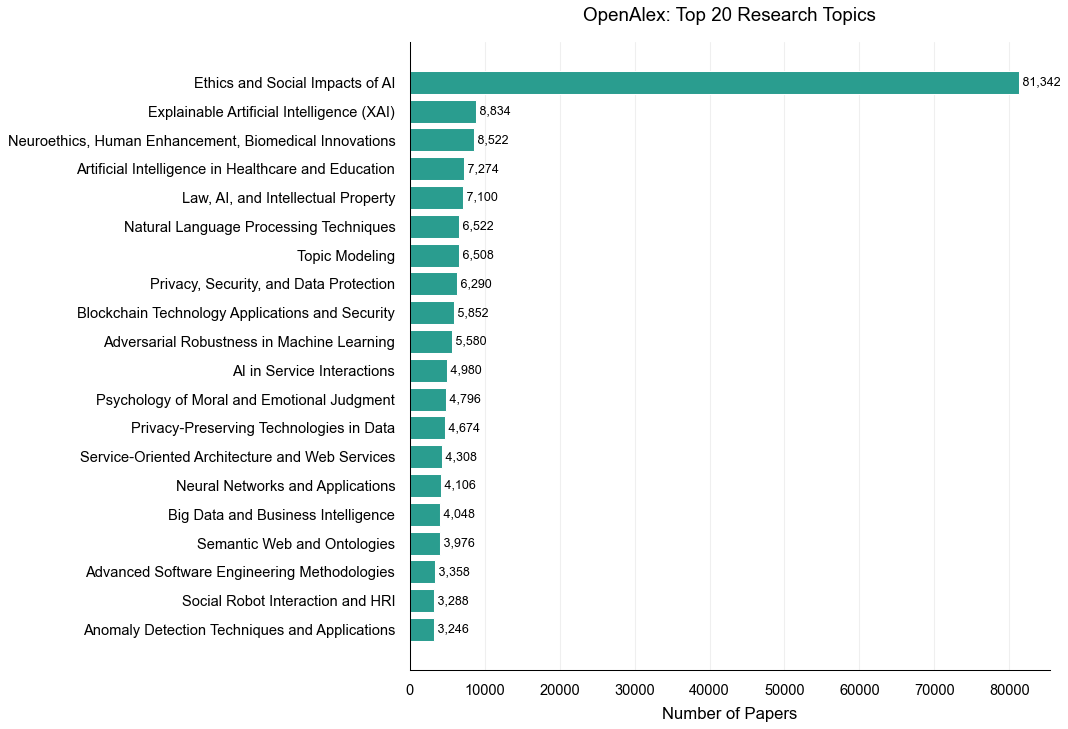

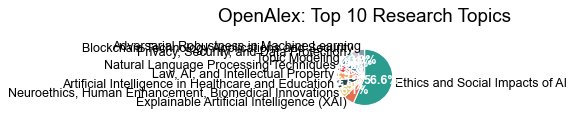


Top 20 Topics by Citation Metrics:
                                                        total_citations  avg_citations  median_citations  paper_count
topic_name                                                                                                           
Ethics and Social Impacts of AI                                 1194940           14.7               1.0        81342
Explainable Artificial Intelligence (XAI)                        305468           34.6               4.0         8834
Topic Modeling                                                   269662           41.4               8.0         6508
Natural Language Processing Techniques                           234846           36.0               6.0         6522
Adversarial Robustness in Machine Learning                       211692           37.9               5.0         5580
Machine Learning and Data Classification                         195724           82.2               8.0         2380
Domain Adaptation an

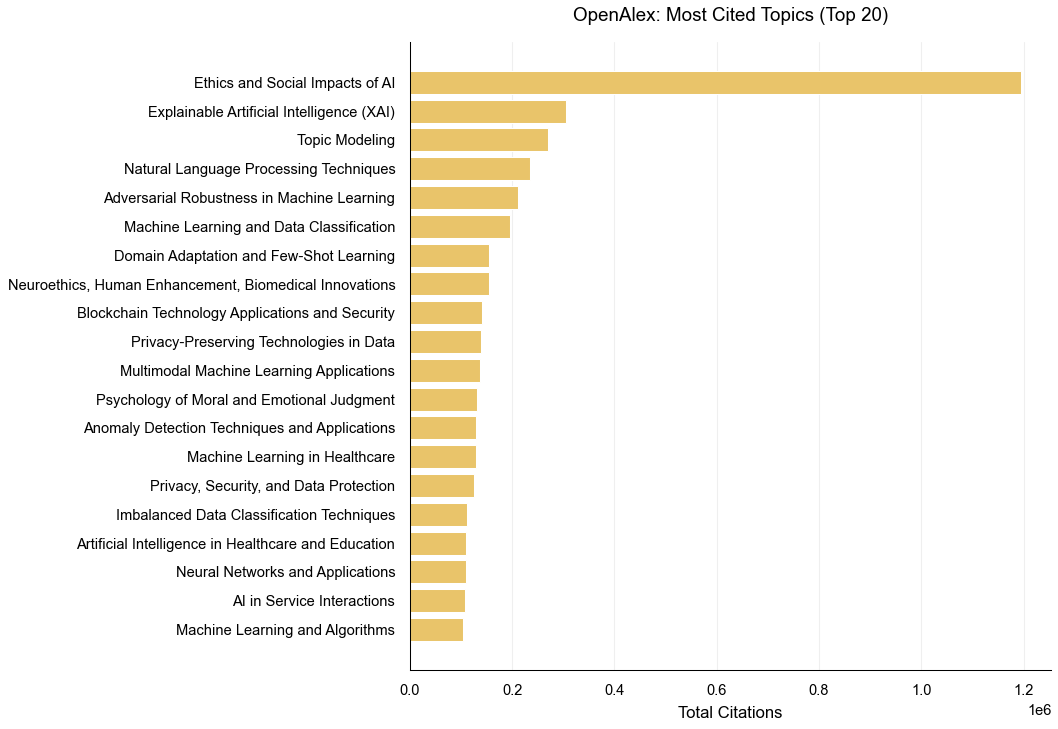

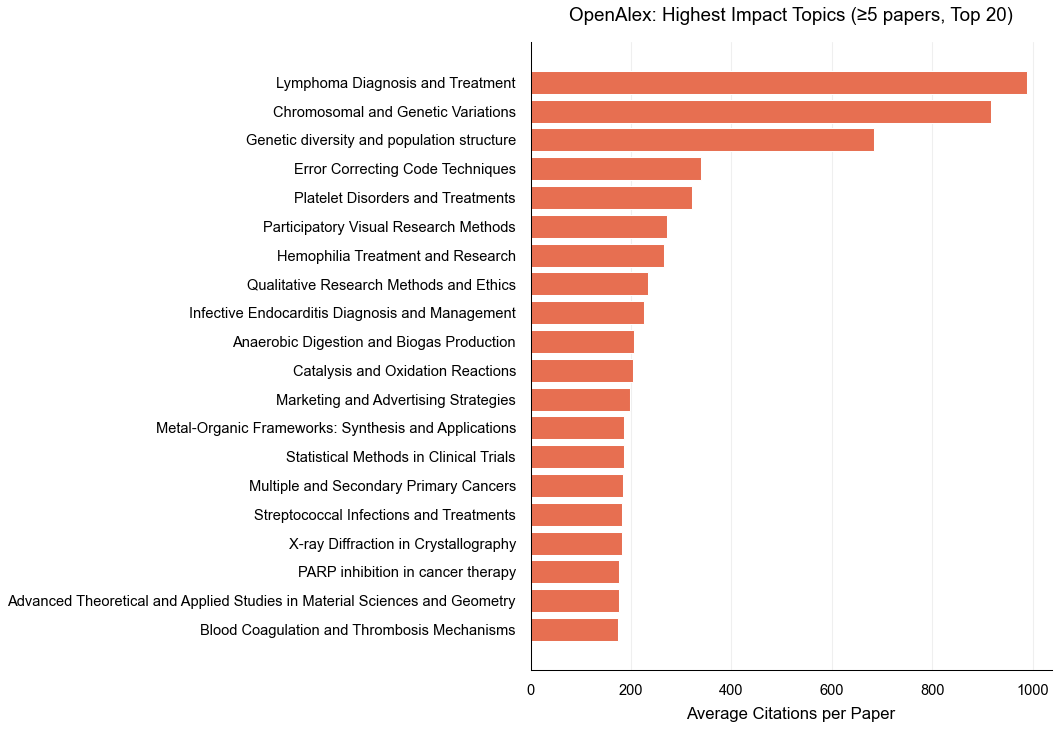

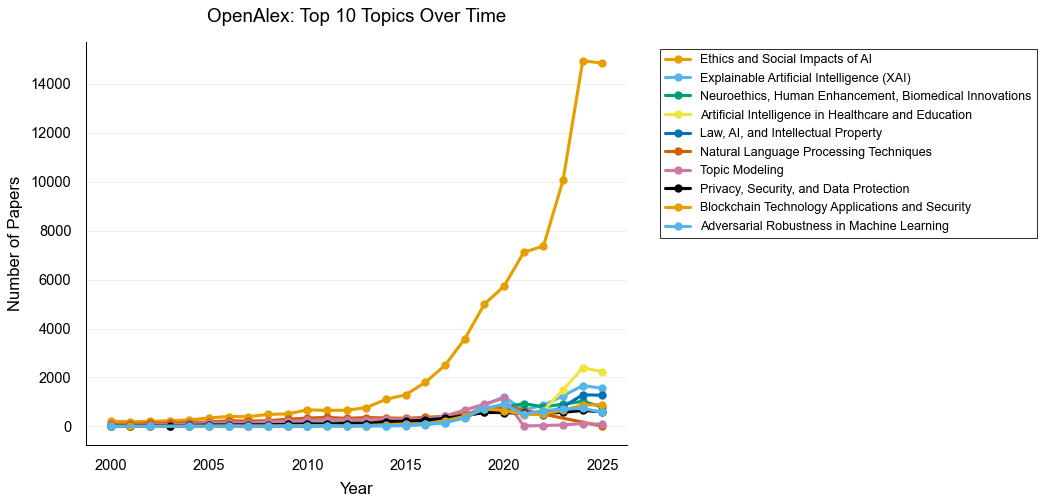

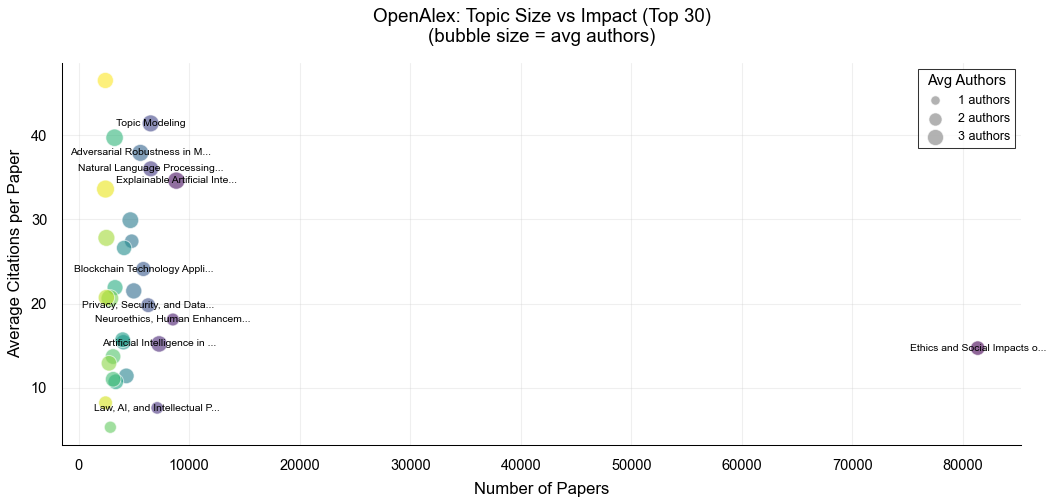


=== OpenAlex topic analysis complete ===


In [183]:
"""=== OPENALEX TOPIC ANALYSIS ==="""

# Create expanded dataframe with one row per topic
all_topics = []
for idx, row in openalex_df.iterrows():
    topics = row['parsed_topics']
    for topic in topics:
        all_topics.append({
            'paper_id': row['id'],
            'topic_name': topic,
            'cited_by_count': row['cited_by_count'],
            'num_authors': row['num_authors'],
            'year': row['year'],
            'publication_year': row['publication_year']
        })

topics_df = pd.DataFrame(all_topics)
print(f"Extracted {len(topics_df)} topic associations from {len(openalex_df)} papers")

if len(topics_df) == 0:
    print("No topics found in OpenAlex data")
else:
    print(f"Unique topics: {topics_df['topic_name'].nunique()}")
    
    # 1. Top Topics Distribution (show top 20)
    topic_counts = topics_df['topic_name'].value_counts().head(20)
    
    print(f"\nTop 20 Topic Distribution:")
    for topic, count in topic_counts.items():
        percentage = (count / len(topics_df)) * 100
        print(f"  {topic}: {count:,} ({percentage:.1f}%)")
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(3.5, len(topic_counts) * 0.25)))
    bars = ax.barh(range(len(topic_counts)), topic_counts.values,
                   color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax.set_yticks(range(len(topic_counts)))
    ax.set_yticklabels(topic_counts.index, fontsize=7)
    ax.set_xlabel('Number of Papers')
    ax.set_title('OpenAlex: Top 20 Research Topics', pad=10)
    ax.invert_yaxis()
    ax.grid(axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f' {int(width):,}',
               ha='left', va='center', fontsize=6)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Topic Distribution (Pie Chart - top 10 only)
    top_10_topics = topics_df['topic_name'].value_counts().head(10)
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        top_10_topics.values,
        labels=top_10_topics.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2a9d8f', '#e76f51', '#e9c46a', '#264653', '#f4a261', 
                '#e63946', '#457b9d', '#a8dadc', '#cccccc', '#8d99ae'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False,
        textprops={'fontsize': 6}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(6)
    
    # Adjust label fontsize
    for text in texts:
        text.set_fontsize(6)
    
    ax.set_title('OpenAlex: Top 10 Research Topics', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Topic Citation Impact (top 20)
    topic_engagement = topics_df.groupby('topic_name').agg({
        'cited_by_count': ['sum', 'mean', 'median'],
        'paper_id': 'count'
    }).round(1)
    
    topic_engagement.columns = ['total_citations', 'avg_citations', 'median_citations', 'paper_count']
    topic_engagement = topic_engagement.sort_values('total_citations', ascending=False).head(20)
    
    print(f"\nTop 20 Topics by Citation Metrics:")
    print(topic_engagement.to_string())
    
    # Total citations by topic
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(3.5, len(topic_engagement) * 0.25)))
    bars = ax.barh(range(len(topic_engagement)), topic_engagement['total_citations'],
                   color='#e9c46a', edgecolor='white', linewidth=0.5)
    ax.set_yticks(range(len(topic_engagement)))
    ax.set_yticklabels(topic_engagement.index, fontsize=7)
    ax.set_xlabel('Total Citations')
    ax.set_title('OpenAlex: Most Cited Topics (Top 20)', pad=10)
    ax.invert_yaxis()
    ax.grid(axis='x')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Average citations by topic
    topic_engagement_avg = topics_df.groupby('topic_name').agg({
        'cited_by_count': 'mean',
        'paper_id': 'count'
    }).round(1)
    topic_engagement_avg.columns = ['avg_citations', 'paper_count']
    # Only topics with at least 5 papers
    topic_engagement_avg = topic_engagement_avg[topic_engagement_avg['paper_count'] >= 5]
    topic_engagement_avg = topic_engagement_avg.sort_values('avg_citations', ascending=False).head(20)
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(3.5, len(topic_engagement_avg) * 0.25)))
    bars = ax.barh(range(len(topic_engagement_avg)), topic_engagement_avg['avg_citations'],
                   color='#e76f51', edgecolor='white', linewidth=0.5)
    ax.set_yticks(range(len(topic_engagement_avg)))
    ax.set_yticklabels(topic_engagement_avg.index, fontsize=7)
    ax.set_xlabel('Average Citations per Paper')
    ax.set_title('OpenAlex: Highest Impact Topics (≥5 papers, Top 20)', pad=10)
    ax.invert_yaxis()
    ax.grid(axis='x')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 4. Topics over time (top 10 only)
    top_10_for_temporal = topics_df['topic_name'].value_counts().head(10).index
    topic_temporal = topics_df[topics_df['topic_name'].isin(top_10_for_temporal)].groupby(['year', 'topic_name']).size().reset_index(name='count')
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    for topic in top_10_for_temporal:
        topic_data = topic_temporal[topic_temporal['topic_name'] == topic]
        ax.plot(topic_data['year'], topic_data['count'], 
               marker='o', linewidth=1.5, markersize=4, label=topic)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Papers')
    ax.set_title('OpenAlex: Top 10 Topics Over Time', pad=10)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
             frameon=True, edgecolor='black', fancybox=False,
             fontsize=6)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 5. Bubble chart: Papers vs Citations (top 30 topics)
    topic_bubble = topics_df.groupby('topic_name').agg({
        'cited_by_count': 'mean',
        'num_authors': 'mean',
        'paper_id': 'count'
    }).round(1)
    topic_bubble.columns = ['avg_citations', 'avg_authors', 'paper_count']
    topic_bubble = topic_bubble[topic_bubble['paper_count'] >= 3].sort_values('paper_count', ascending=False).head(30)
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    scatter = ax.scatter(
        topic_bubble['paper_count'],
        topic_bubble['avg_citations'],
        s=topic_bubble['avg_authors'] * 20,
        c=np.arange(len(topic_bubble)),
        cmap='viridis',
        alpha=0.6,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add labels for top 10 only
    for idx, row in topic_bubble.head(10).iterrows():
        label = idx if len(idx) <= 30 else idx[:27] + '...'
        ax.annotate(label, 
                   (row['paper_count'], row['avg_citations']),
                   fontsize=5,
                   ha='center',
                   va='center')
    
    ax.set_xlabel('Number of Papers')
    ax.set_ylabel('Average Citations per Paper')
    ax.set_title('OpenAlex: Topic Size vs Impact (Top 30)\n(bubble size = avg authors)', pad=10)
    ax.grid(True, alpha=0.3)
    
    # Add legend for bubble size
    sizes = [int(topic_bubble['avg_authors'].min()), 
             int(topic_bubble['avg_authors'].mean()), 
             int(topic_bubble['avg_authors'].max())]
    labels = [f'{s} authors' for s in sizes]
    legend_elements = [plt.scatter([], [], s=s*20, c='gray', alpha=0.6,
                                   edgecolors='white', linewidth=0.5)
                      for s in sizes]
    ax.legend(legend_elements, labels,
             title='Avg Authors',
             loc='upper right',
             frameon=True,
             edgecolor='black',
             fancybox=False,
             fontsize=6)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    print("\n=== OpenAlex topic analysis complete ===")

## Gender Analysis

In [184]:
print("\n=== OPENALEX GENDER ANALYSIS ===")

# Parse author_genders column (semicolon-separated string)
def parse_genders(gender_str):
    """Parse author genders from semicolon-separated string."""
    if pd.isna(gender_str):
        return []
    # Split by semicolon and clean whitespace, convert to lowercase
    genders = [g.strip().lower() for g in str(gender_str).split(';') if g.strip()]
    return genders

# Extract gender information
print("Parsing author gender data...")
openalex_df['parsed_genders'] = openalex_df['author_genders'].apply(parse_genders)
openalex_df['num_genders'] = openalex_df['parsed_genders'].apply(len)


=== OPENALEX GENDER ANALYSIS ===
Parsing author gender data...


In [187]:
# Create expanded dataframe with one row per author
all_authors = []
for idx, row in openalex_df.iterrows():
    genders = row['parsed_genders']
    for gender in genders:
        all_authors.append({
            'paper_id': row['id'],
            'gender': gender,
            'year': row['year'],
            'cited_by_count': row['cited_by_count'],
            'num_authors': row['num_authors'],
            'publication_year': row['publication_year']
        })

authors_df = pd.DataFrame(all_authors)
print(f"Extracted {len(authors_df)} author records from {len(openalex_df)} papers")

Extracted 398577 author records from 274562 papers



Author Gender Distribution:
  GM: 235,445 (59.1%)
  GF: 146,771 (36.8%)
  -: 15,499 (3.9%)
  –: 862 (0.2%)

Paper Gender Composition (ignoring unknown):
  Papers with ≥1 female author: 81,849 (29.8%)
  Papers with ≥1 male author: 105,484 (38.4%)
  Papers with no known genders: 139,790 (50.9%)


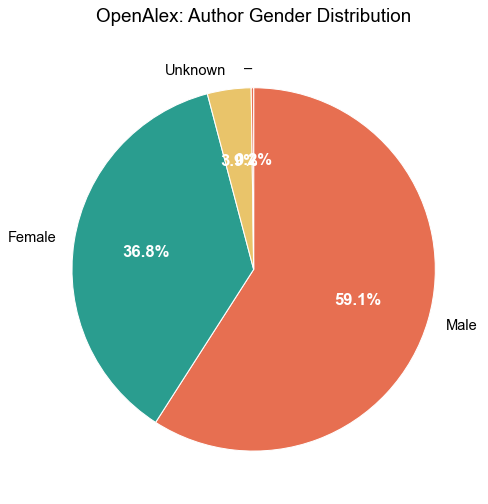

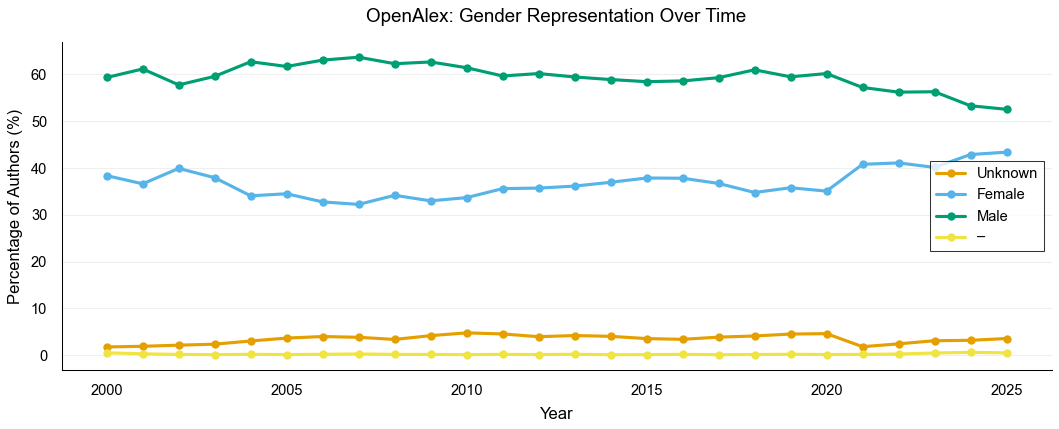

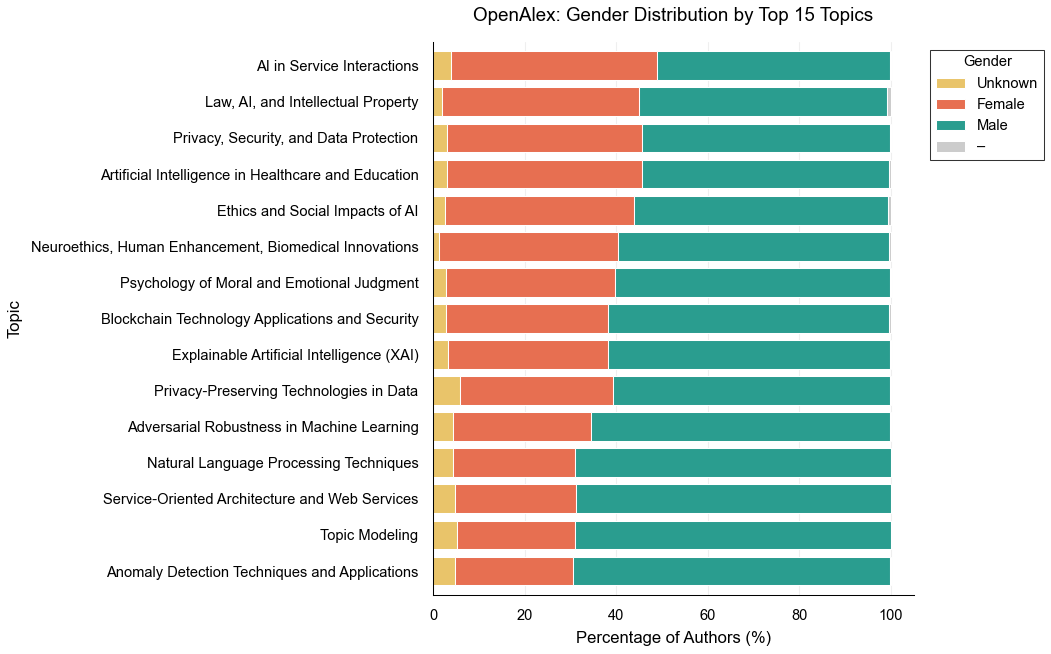


Team Composition (unknowns ignored):
  No Known Gender: 139,790 papers (50.9%)
  Male-only: 52,923 papers (19.3%)
  Mixed: 52,561 papers (19.1%)
  Female-only: 29,288 papers (10.7%)


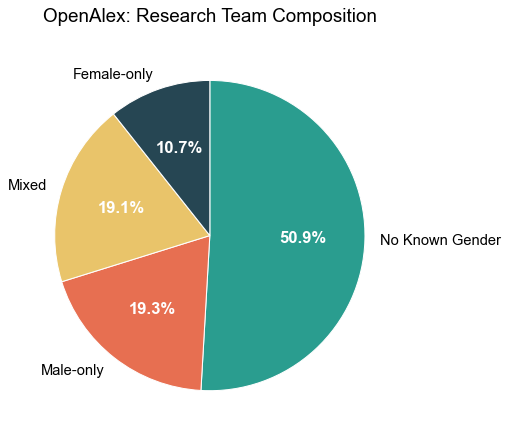

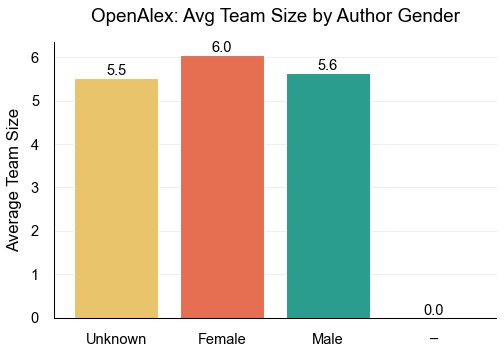

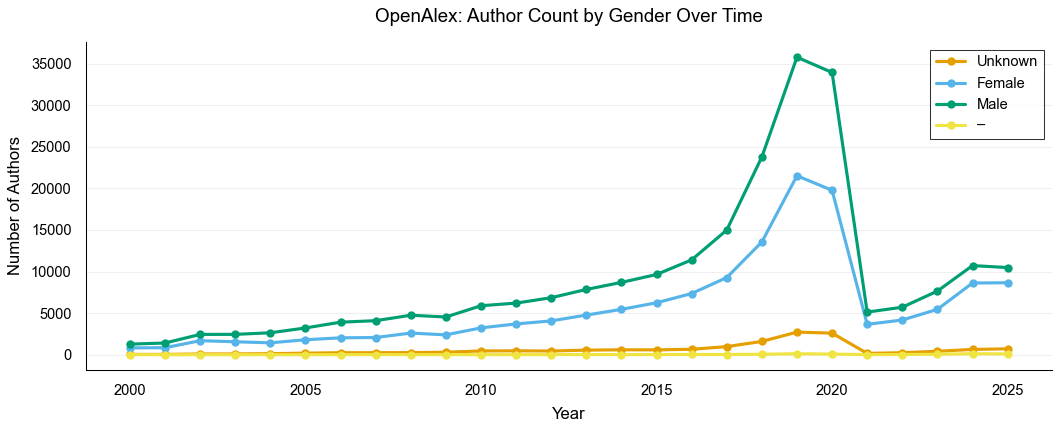


=== OpenAlex gender analysis complete ===


In [188]:
if len(authors_df) == 0:
    print("No gender data found in OpenAlex")
else:
    # Clean gender labels
    gender_counts = authors_df['gender'].value_counts()
    print(f"\nAuthor Gender Distribution:")
    for gender, count in gender_counts.items():
        percentage = (count / len(authors_df)) * 100
        print(f"  {gender.upper()}: {count:,} ({percentage:.1f}%)")
    
    # Paper-level gender composition - IGNORE unknowns
    openalex_df['has_female'] = openalex_df['parsed_genders'].apply(
        lambda x: any(g in ['gf', 'female', 'f'] for g in x) if isinstance(x, list) else False
    )
    openalex_df['has_male'] = openalex_df['parsed_genders'].apply(
        lambda x: any(g in ['gm', 'male', 'm'] for g in x) if isinstance(x, list) else False
    )
    # Only count as "all unknown" if there are NO known genders at all
    openalex_df['has_any_known'] = openalex_df['has_female'] | openalex_df['has_male']
    
    print(f"\nPaper Gender Composition (ignoring unknown):")
    print(f"  Papers with ≥1 female author: {openalex_df['has_female'].sum():,} ({openalex_df['has_female'].sum()/len(openalex_df)*100:.1f}%)")
    print(f"  Papers with ≥1 male author: {openalex_df['has_male'].sum():,} ({openalex_df['has_male'].sum()/len(openalex_df)*100:.1f}%)")
    print(f"  Papers with no known genders: {(~openalex_df['has_any_known']).sum():,} ({(~openalex_df['has_any_known']).sum()/len(openalex_df)*100:.1f}%)")
    
    # 1. Overall gender distribution (authors) - including unknown for transparency
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    
    # Map to cleaner labels
    label_map = {'gf': 'Female', 'gm': 'Male', 'unknown': 'Unknown', '-': 'Unknown'}
    clean_labels = [label_map.get(g, g.title()) for g in gender_counts.index]
    
    wedges, texts, autotexts = ax.pie(
        gender_counts.values,
        labels=clean_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#e76f51', '#2a9d8f', '#e9c46a'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title('OpenAlex: Author Gender Distribution', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Gender trends over time
    gender_temporal = authors_df.groupby(['year', 'gender']).size().unstack(fill_value=0)
    
    # Calculate percentages
    gender_temporal_pct = gender_temporal.div(gender_temporal.sum(axis=1), axis=0) * 100
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
    
    for gender in gender_temporal_pct.columns:
        display_label = label_map.get(gender, gender.title())
        ax.plot(gender_temporal_pct.index, gender_temporal_pct[gender],
               marker='o', linewidth=1.5, markersize=4, label=display_label)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Authors (%)')
    ax.set_title('OpenAlex: Gender Representation Over Time', pad=10)
    ax.legend(frameon=True, edgecolor='black', fancybox=False)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Gender by topic (if topics available - top 15 topics only)
    if len(topics_df) > 0:
        # Merge topics with authors
        topic_gender = topics_df.merge(
            authors_df[['paper_id', 'gender']], 
            on='paper_id', 
            how='left'
        )
        
        # Get top 15 topics
        top_topics_for_gender = topic_gender['topic_name'].value_counts().head(15).index
        topic_gender_filtered = topic_gender[topic_gender['topic_name'].isin(top_topics_for_gender)]
        
        # Calculate gender distribution by topic
        topic_gender_dist = topic_gender_filtered.groupby(['topic_name', 'gender']).size().unstack(fill_value=0)
        
        # Calculate percentages
        topic_gender_pct = topic_gender_dist.div(topic_gender_dist.sum(axis=1), axis=0) * 100
        
        # Sort by female percentage if available
        if 'gf' in topic_gender_pct.columns:
            topic_gender_pct = topic_gender_pct.sort_values('gf', ascending=True)
        
        fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(4, len(topic_gender_pct) * 0.3)))
        
        # Create color mapping
        color_map = {'gf': '#e76f51', 'gm': '#2a9d8f', 'unknown': '#e9c46a', '-': '#e9c46a'}
        colors = [color_map.get(col, '#cccccc') for col in topic_gender_pct.columns]
        
        topic_gender_pct.plot(kind='barh', stacked=True, ax=ax,
                              color=colors,
                              width=0.8,
                              edgecolor='white',
                              linewidth=0.5)
        
        ax.set_xlabel('Percentage of Authors (%)')
        ax.set_ylabel('Topic')
        ax.set_title('OpenAlex: Gender Distribution by Top 15 Topics', pad=10)
        
        # Clean up legend labels
        handles, labels = ax.get_legend_handles_labels()
        clean_legend_labels = [label_map.get(l, l.title()) for l in labels]
        ax.legend(handles, clean_legend_labels, title='Gender', 
                 bbox_to_anchor=(1.02, 1), loc='upper left',
                 frameon=True, edgecolor='black', fancybox=False)
        ax.grid(axis='x')
        
        plt.tight_layout()
        plt.show()
        plt.close()
    
    # 4. Team composition analysis - IGNORE unknowns in classification
    openalex_df['team_type'] = 'No Known Gender'
    openalex_df.loc[openalex_df['has_female'] & openalex_df['has_male'], 'team_type'] = 'Mixed'
    openalex_df.loc[openalex_df['has_female'] & ~openalex_df['has_male'], 'team_type'] = 'Female-only'
    openalex_df.loc[~openalex_df['has_female'] & openalex_df['has_male'], 'team_type'] = 'Male-only'
    
    team_counts = openalex_df['team_type'].value_counts()
    
    print(f"\nTeam Composition (unknowns ignored):")
    for team_type, count in team_counts.items():
        percentage = (count / len(openalex_df)) * 100
        print(f"  {team_type}: {count:,} papers ({percentage:.1f}%)")
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        team_counts.values,
        labels=team_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2a9d8f', '#e76f51', '#e9c46a', '#264653'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title('OpenAlex: Research Team Composition', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 5. Average team size by gender
    gender_team_size = authors_df.groupby('gender')['num_authors'].mean()
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 2.5))
    
    display_labels = [label_map.get(g, g.title()) for g in gender_team_size.index]
    colors_list = ['#e76f51' if 'gf' in g else '#2a9d8f' if 'gm' in g else '#e9c46a' 
                   for g in gender_team_size.index]
    
    bars = ax.bar(range(len(gender_team_size)), gender_team_size.values,
                  color=colors_list,
                  edgecolor='white',
                  linewidth=0.5)
    
    ax.set_xticks(range(len(gender_team_size)))
    ax.set_xticklabels(display_labels)
    ax.set_ylabel('Average Team Size')
    ax.set_title('OpenAlex: Avg Team Size by Author Gender', pad=10)
    ax.grid(axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}',
               ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 6. Gender over time (absolute numbers)
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
    
    for gender in gender_temporal.columns:
        display_label = label_map.get(gender, gender.title())
        ax.plot(gender_temporal.index, gender_temporal[gender],
               marker='o', linewidth=1.5, markersize=4, label=display_label)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Authors')
    ax.set_title('OpenAlex: Author Count by Gender Over Time', pad=10)
    ax.legend(frameon=True, edgecolor='black', fancybox=False)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== OpenAlex gender analysis complete ===")

## Temporal Analysis


=== OPENALEX TEMPORAL ANALYSIS ===

Papers by Year:
  2000: 2,116 papers
  2001: 2,234 papers
  2002: 3,820 papers
  2003: 3,588 papers
  2004: 3,876 papers
  2005: 4,742 papers
  2006: 5,464 papers
  2007: 5,668 papers
  2008: 6,332 papers
  2009: 6,344 papers
  2010: 7,728 papers
  2011: 8,358 papers
  2012: 8,980 papers
  2013: 9,848 papers
  2014: 10,846 papers
  2015: 11,708 papers
  2016: 12,934 papers
  2017: 16,348 papers
  2018: 23,512 papers
  2019: 34,300 papers
  2020: 31,454 papers
  2021: 7,120 papers
  2022: 7,370 papers
  2023: 10,070 papers
  2024: 14,956 papers
  2025: 14,846 papers


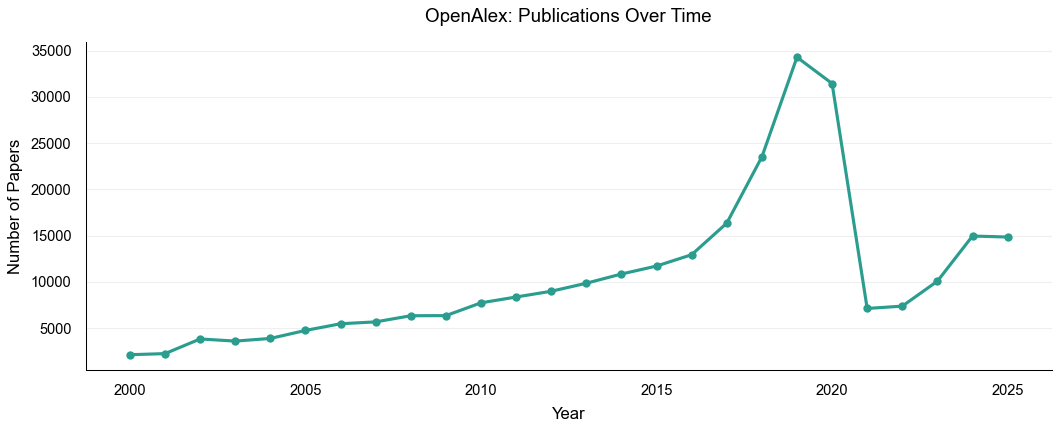


Citations by Year:
                  total_citations  avg_citations  median_citations
publication_year                                                  
2000                        62312           29.4               4.0
2001                        78980           35.4               3.0
2002                       117378           30.7               3.0
2003                       107802           30.0               3.5
2004                       123630           31.9               3.0
2005                       106644           22.5               3.0
2006                       123374           22.6               3.0
2007                       203046           35.8               3.0
2008                       152124           24.0               3.0
2009                       199090           31.4               3.0
2010                       222300           28.8               2.0
2011                       154528           18.5               2.0
2012                       203942         

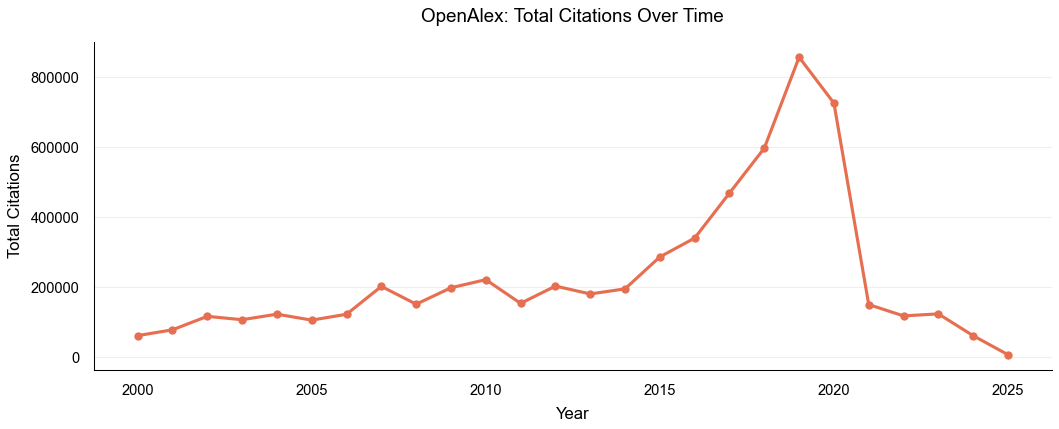

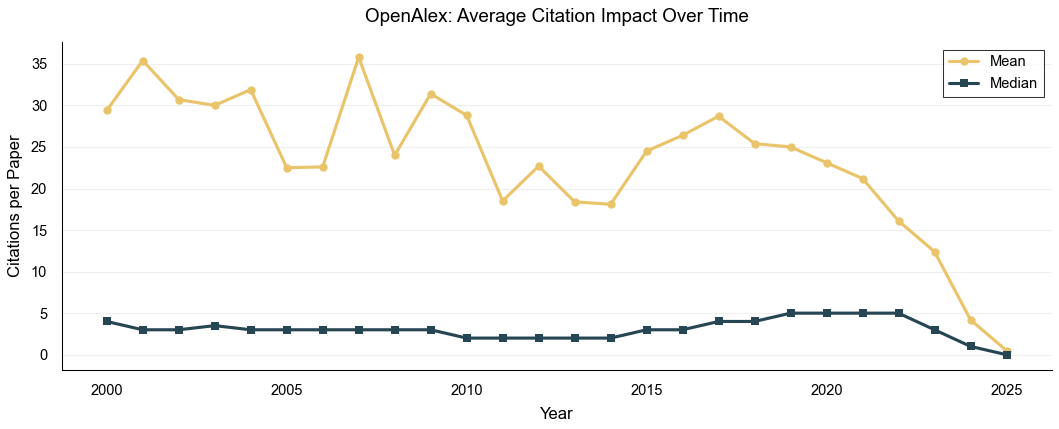


Collaboration Trends:
                  avg_authors  median_authors
publication_year                             
2000                      2.0             1.0
2001                      2.1             1.0
2002                      2.2             2.0
2003                      2.3             2.0
2004                      2.2             2.0
2005                      2.2             2.0
2006                      2.3             2.0
2007                      2.3             2.0
2008                      2.4             2.0
2009                      2.3             2.0
2010                      2.5             2.0
2011                      2.5             2.0
2012                      2.5             2.0
2013                      2.7             2.0
2014                      2.7             2.0
2015                      2.8             2.0
2016                      3.0             2.0
2017                      3.1             2.0
2018                      3.3             3.0
2019       

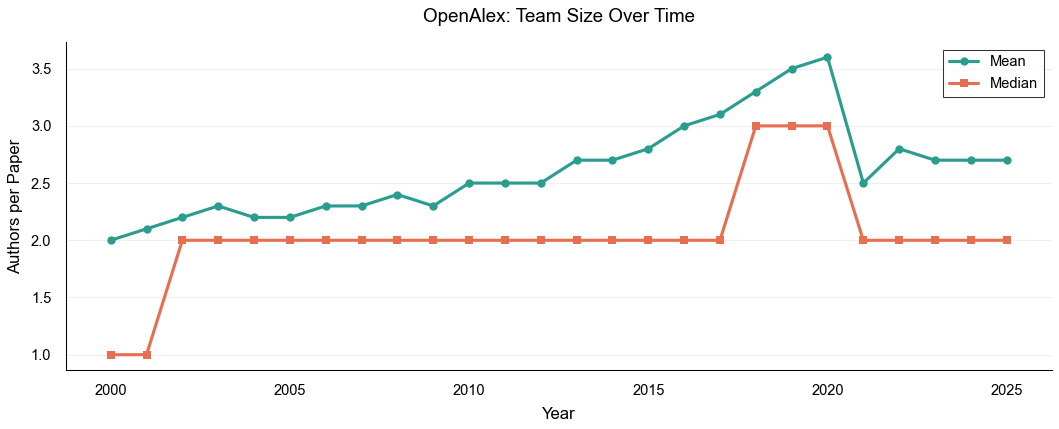

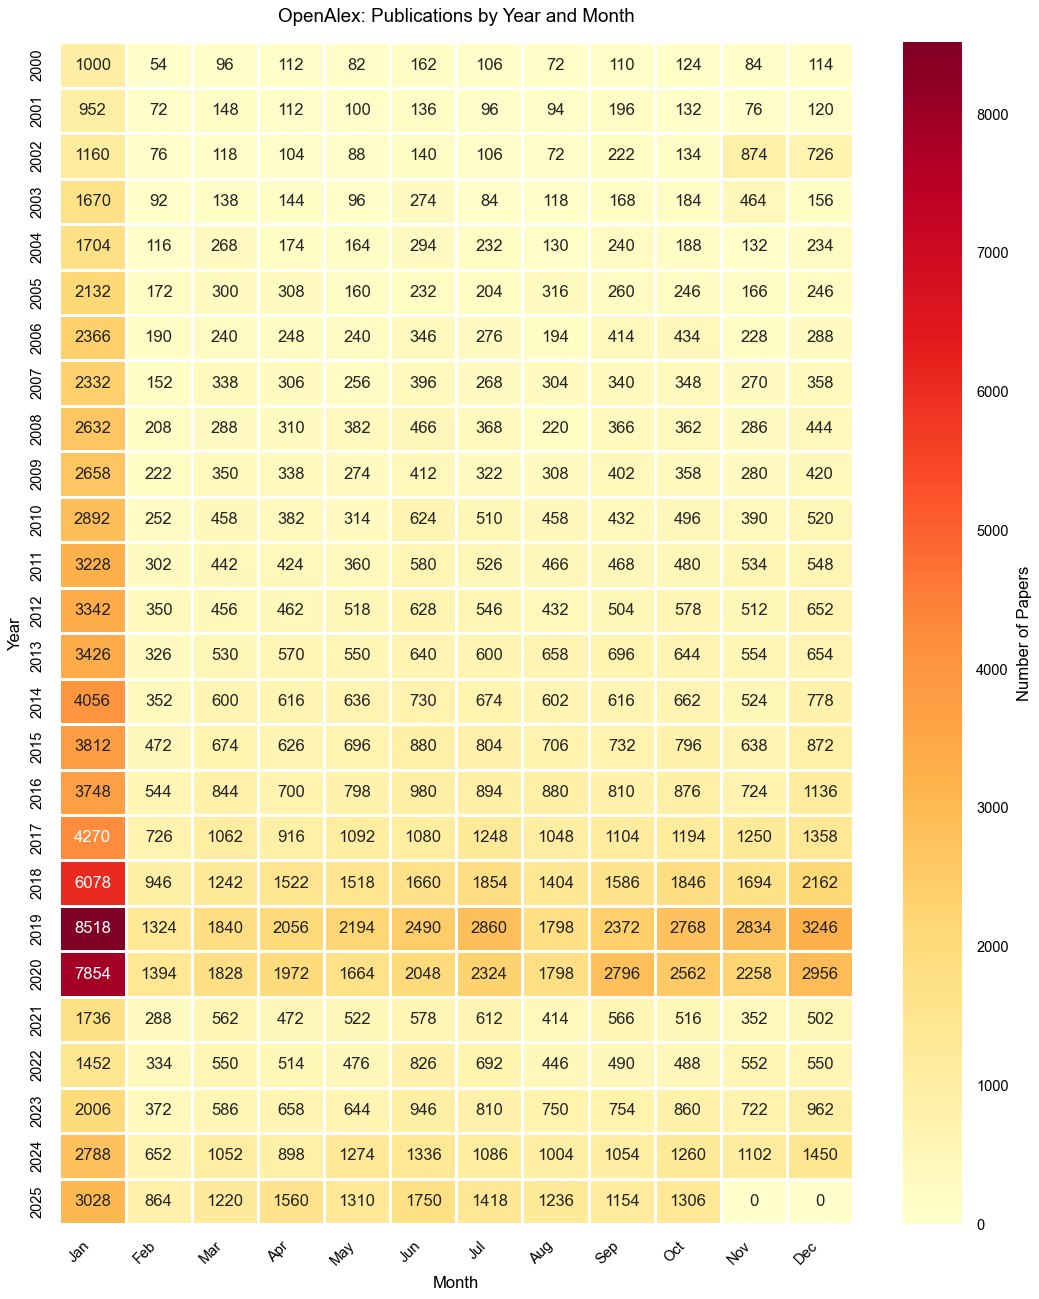

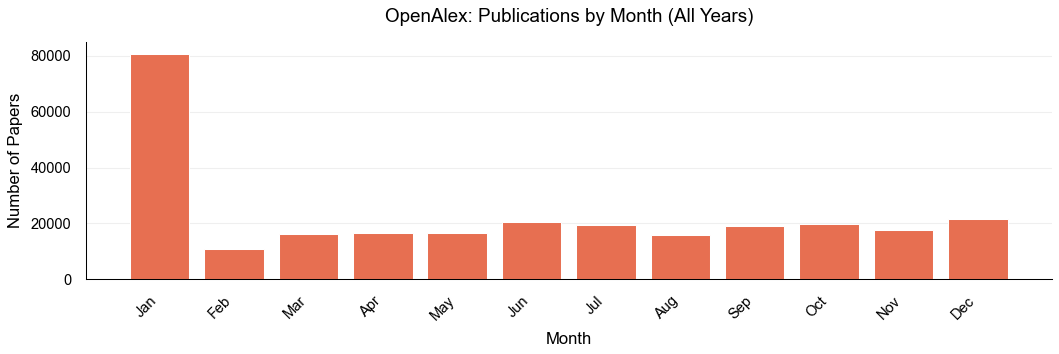

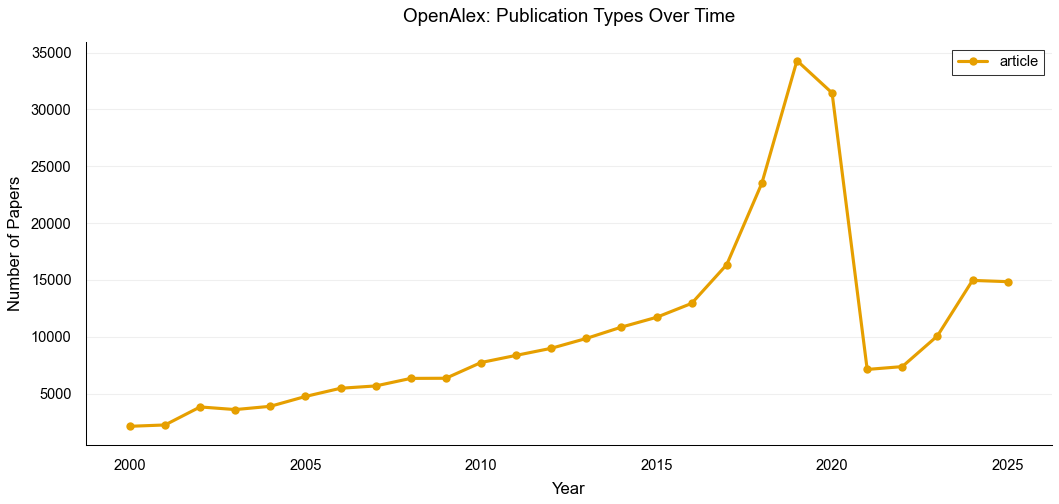


Year-over-Year Growth Rate:
  2001: +5.6%
  2002: +71.0%
  2003: -6.1%
  2004: +8.0%
  2005: +22.3%
  2006: +15.2%
  2007: +3.7%
  2008: +11.7%
  2009: +0.2%
  2010: +21.8%
  2011: +8.2%
  2012: +7.4%
  2013: +9.7%
  2014: +10.1%
  2015: +7.9%
  2016: +10.5%
  2017: +26.4%
  2018: +43.8%
  2019: +45.9%
  2020: -8.3%
  2021: -77.4%
  2022: +3.5%
  2023: +36.6%
  2024: +48.5%
  2025: -0.7%


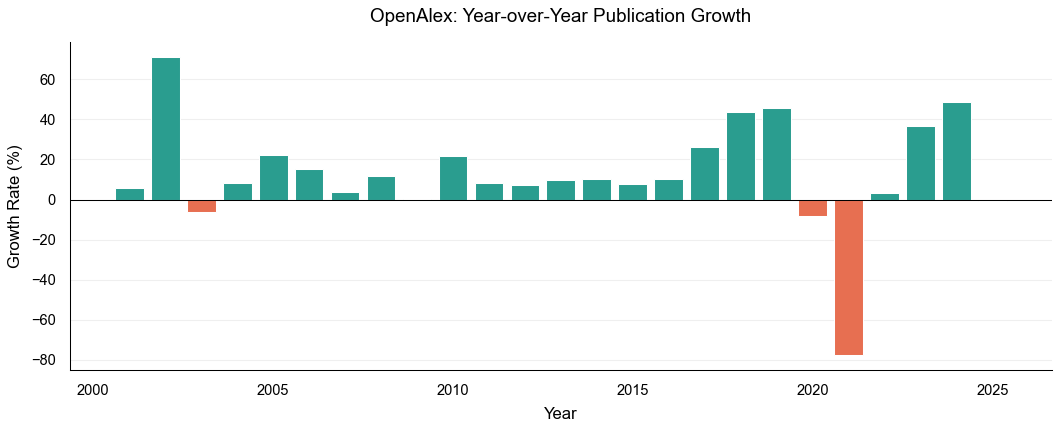

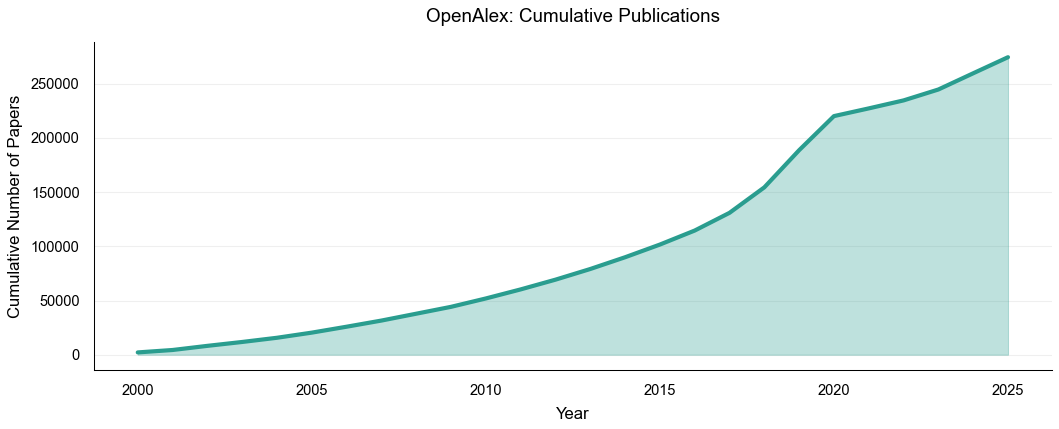

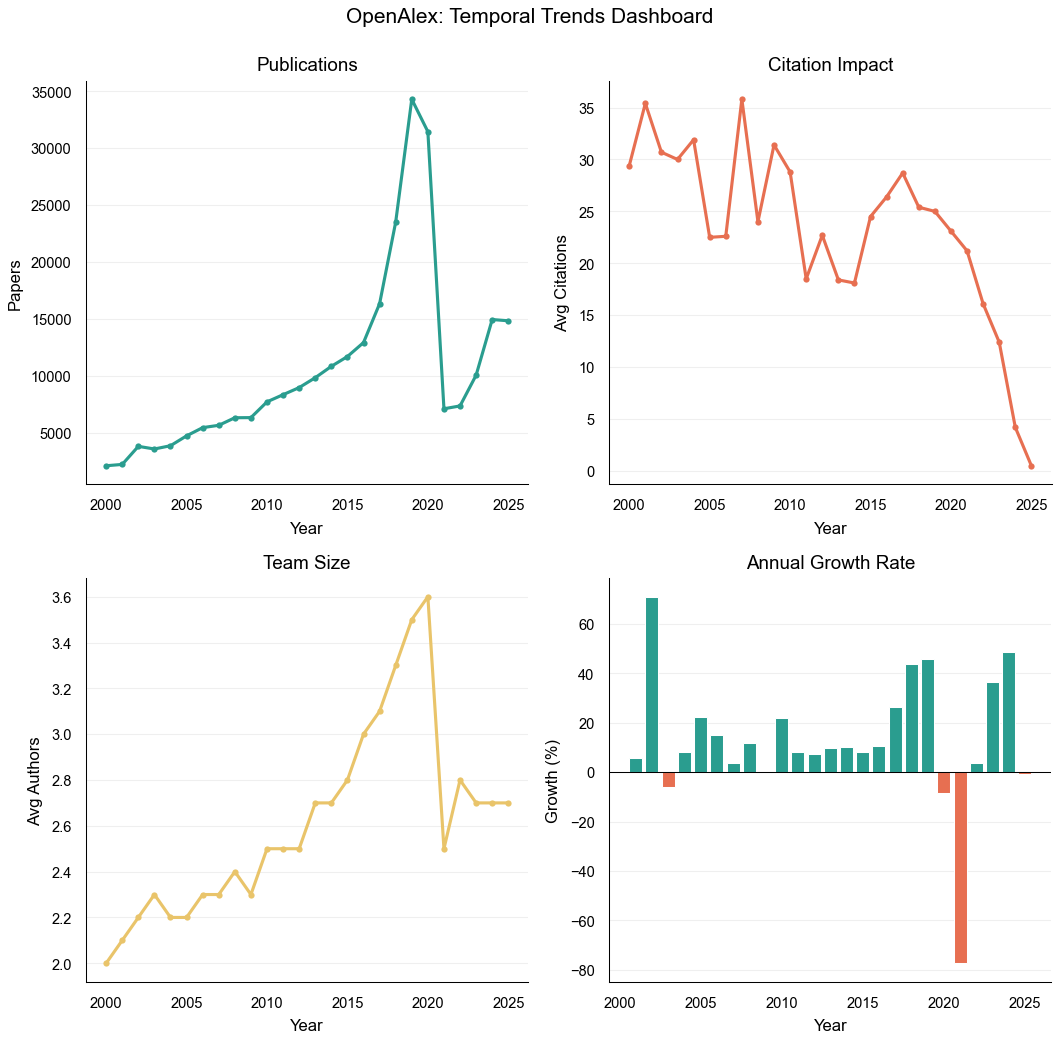


=== OpenAlex temporal analysis complete ===


In [190]:
"""=== OPENALEX TEMPORAL ANALYSIS ==="""

print("\n=== OPENALEX TEMPORAL ANALYSIS ===")

# 1. Papers by year
yearly_papers = openalex_df.groupby('publication_year').size()

print(f"\nPapers by Year:")
for year, count in yearly_papers.items():
    print(f"  {year}: {count:,} papers")

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_papers.index, yearly_papers.values,
        marker='o', linewidth=1.5, markersize=4, color='#2a9d8f')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
ax.set_title('OpenAlex: Publications Over Time', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 2. Citations over time
yearly_citations = openalex_df.groupby('publication_year').agg({
    'cited_by_count': ['sum', 'mean', 'median']
}).round(1)
yearly_citations.columns = ['total_citations', 'avg_citations', 'median_citations']

print(f"\nCitations by Year:")
print(yearly_citations.to_string())

# Total citations
fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_citations.index, yearly_citations['total_citations'],
        marker='o', linewidth=1.5, markersize=4, color='#e76f51')
ax.set_xlabel('Year')
ax.set_ylabel('Total Citations')
ax.set_title('OpenAlex: Total Citations Over Time', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# Average citations
fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_citations.index, yearly_citations['avg_citations'],
        marker='o', linewidth=1.5, markersize=4, color='#e9c46a', label='Mean')
ax.plot(yearly_citations.index, yearly_citations['median_citations'],
        marker='s', linewidth=1.5, markersize=4, color='#264653', label='Median')
ax.set_xlabel('Year')
ax.set_ylabel('Citations per Paper')
ax.set_title('OpenAlex: Average Citation Impact Over Time', pad=10)
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 3. Collaboration trends (authors per paper)
yearly_collaboration = openalex_df.groupby('publication_year').agg({
    'num_authors': ['mean', 'median']
}).round(1)
yearly_collaboration.columns = ['avg_authors', 'median_authors']

print(f"\nCollaboration Trends:")
print(yearly_collaboration.to_string())

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_collaboration.index, yearly_collaboration['avg_authors'],
        marker='o', linewidth=1.5, markersize=4, color='#2a9d8f', label='Mean')
ax.plot(yearly_collaboration.index, yearly_collaboration['median_authors'],
        marker='s', linewidth=1.5, markersize=4, color='#e76f51', label='Median')
ax.set_xlabel('Year')
ax.set_ylabel('Authors per Paper')
ax.set_title('OpenAlex: Team Size Over Time', pad=10)
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 4. Monthly heatmap (if month data available)
if 'month' in openalex_df.columns:
    heatmap_data = openalex_df.groupby(['publication_year', 'month']).size().unstack(fill_value=0)
    
    # Ensure all months 1-12 are present
    for month in range(1, 13):
        if month not in heatmap_data.columns:
            heatmap_data[month] = 0
    heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, len(heatmap_data) * 0.3 + 1))
    
    import seaborn as sns
    sns.heatmap(heatmap_data, annot=True, fmt='d',
                cmap='YlOrRd',
                ax=ax,
                cbar_kws={'label': 'Number of Papers'},
                linewidths=0.5,
                linecolor='white')
    
    ax.set_title('OpenAlex: Publications by Year and Month', pad=10)
    ax.set_xlabel('Month')
    ax.set_ylabel('Year')
    
    # Set month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(month_labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Monthly aggregated pattern
    monthly_papers = openalex_df.groupby('month').size()
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 2.5))
    bars = ax.bar(monthly_papers.index, monthly_papers.values,
                  color='#e76f51', edgecolor='white', linewidth=0.5)
    ax.set_title('OpenAlex: Publications by Month (All Years)', pad=10)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Papers')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                      rotation=45, ha='right')
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# 5. Paper type distribution over time (if type column exists)
if 'type' in openalex_df.columns and openalex_df['type'].notna().sum() > 0:
    type_temporal = openalex_df.groupby(['publication_year', 'type']).size().unstack(fill_value=0)
    
    # Get top 5 types
    top_types = openalex_df['type'].value_counts().head(5).index
    type_temporal_filtered = type_temporal[top_types]
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    for pub_type in top_types:
        ax.plot(type_temporal_filtered.index, type_temporal_filtered[pub_type],
               marker='o', linewidth=1.5, markersize=4, label=pub_type)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Papers')
    ax.set_title('OpenAlex: Publication Types Over Time', pad=10)
    ax.legend(frameon=True, edgecolor='black', fancybox=False)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# 6. Growth rate analysis
yearly_papers_sorted = yearly_papers.sort_index()
growth_rate = yearly_papers_sorted.pct_change() * 100

print(f"\nYear-over-Year Growth Rate:")
for year, rate in growth_rate.items():
    if not pd.isna(rate):
        print(f"  {year}: {rate:+.1f}%")

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.bar(growth_rate.index, growth_rate.values,
       color=['#2a9d8f' if x > 0 else '#e76f51' for x in growth_rate.values],
       edgecolor='white', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Growth Rate (%)')
ax.set_title('OpenAlex: Year-over-Year Publication Growth', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 7. Cumulative papers over time
cumulative_papers = yearly_papers_sorted.cumsum()

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.fill_between(cumulative_papers.index, cumulative_papers.values,
                alpha=0.3, color='#2a9d8f')
ax.plot(cumulative_papers.index, cumulative_papers.values,
        linewidth=2, color='#2a9d8f')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Number of Papers')
ax.set_title('OpenAlex: Cumulative Publications', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 8. Combined metrics dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(DOUBLE_COL, 7))

# Papers over time
ax1.plot(yearly_papers.index, yearly_papers.values,
         marker='o', linewidth=1.5, markersize=3, color='#2a9d8f')
ax1.set_xlabel('Year')
ax1.set_ylabel('Papers')
ax1.set_title('Publications', pad=5)
ax1.grid(axis='y', alpha=0.3)

# Citations over time
ax2.plot(yearly_citations.index, yearly_citations['avg_citations'],
         marker='o', linewidth=1.5, markersize=3, color='#e76f51')
ax2.set_xlabel('Year')
ax2.set_ylabel('Avg Citations')
ax2.set_title('Citation Impact', pad=5)
ax2.grid(axis='y', alpha=0.3)

# Collaboration trends
ax3.plot(yearly_collaboration.index, yearly_collaboration['avg_authors'],
         marker='o', linewidth=1.5, markersize=3, color='#e9c46a')
ax3.set_xlabel('Year')
ax3.set_ylabel('Avg Authors')
ax3.set_title('Team Size', pad=5)
ax3.grid(axis='y', alpha=0.3)

# Growth rate
ax4.bar(growth_rate.index, growth_rate.values,
        color=['#2a9d8f' if x > 0 else '#e76f51' for x in growth_rate.values],
        edgecolor='white', linewidth=0.5)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Year')
ax4.set_ylabel('Growth (%)')
ax4.set_title('Annual Growth Rate', pad=5)
ax4.grid(axis='y', alpha=0.3)

fig.suptitle('OpenAlex: Temporal Trends Dashboard', fontsize=10, y=0.995)
plt.tight_layout()
plt.show()
plt.close()

print("\n=== OpenAlex temporal analysis complete ===")

---
# Edges
---

## What coverage of DOIs does OpenAlex data provide for LessWrong posts?

In [81]:
import re
import pandas as pd

def extract_doi_from_link(link):
    """
    Extract clean DOI from any URL, removing URL fragments and query params
    """
    if not link or not isinstance(link, str):
        return None
    
    # Find DOI pattern (10.xxxx/...)
    doi_match = re.search(r'10\.\d{4,9}/[^\s;<>"?#]+', link, re.IGNORECASE)
    if not doi_match:
        return None
    
    doi = doi_match.group()
    
    # Remove common URL fragments that aren't part of the DOI
    # These often appear after the DOI in URLs
    doi = re.sub(r'/(abstract|full|pdf|epdf|summary)$', '', doi, flags=re.IGNORECASE)
    
    # Remove trailing punctuation
    doi = re.sub(r'[.,;:)\]]+$', '', doi)
    
    return doi.strip().lower()

def normalize_doi(doi_string):
    """Normalize DOI by removing URL prefixes"""
    if not doi_string or not isinstance(doi_string, str):
        return None
    
    doi = doi_string.strip().lower()
    # Remove URL wrappers
    doi = re.sub(r'https?://(dx\.)?doi\.org/', '', doi)
    doi = re.sub(r'doi:', '', doi)
    
    return doi.strip() if doi else None

In [82]:
doi_extracted = [extract_doi_from_link(link) for link in clean_links]
doi_clean_list = [d for d in doi_extracted if d]
df_doi = pd.DataFrame({'doi_clean': doi_clean_list}).drop_duplicates()

In [133]:
nodes = pd.read_csv("../data/nodes_openalex_works.csv")
nodes['doi_clean'] = nodes['openalex_doi'].apply(normalize_doi)

In [134]:
matched_doi = df_doi.merge(
    nodes[['openalex_id', 'doi_clean']],
    on='doi_clean',
    how='inner'
)

In [135]:
total_unique_citations = len(df_doi)
matched_count = len(matched_doi)
coverage = matched_count / total_unique_citations

print(f"Total unique DOI citations: {total_unique_citations}")
print(f"Matched in OpenAlex: {matched_count}")
print(f"Coverage: {coverage:.1%}")


Total unique DOI citations: 4398
Matched in OpenAlex: 106
Coverage: 2.4%


In [136]:
if coverage < 0.3:  # If less than 30%
    print("\n⚠️ Low coverage detected. Checking reasons...")
    
    # Sample unmatched DOIs
    matched_set = set(matched_doi['doi_clean'])
    unmatched = df_doi[~df_doi['doi_clean'].isin(matched_set)]
    
    print(f"\nSample unmatched DOIs (first 10):")
    for doi in unmatched['doi_clean'].head(10):
        print(f"  {doi}")


⚠️ Low coverage detected. Checking reasons...

Sample unmatched DOIs (first 10):
  10.1007/s11238-006-9004-4
  10.1080/01621459.1995.10476620
  10.1038/nj7312-240a
  10.1371/journal.pone.0065522
  10.1002/14651858.cd000371.pub5
  10.1002/9781119993384
  10.1111/j.1753-4887.1974.tb05180.x
  10.1080/13674679908406332
  10.1521/jscp.23.5.603.50748
  10.1521/jscp.2000.19.1.56


In [137]:
import time 
import requests

def check_doi_in_openalex(doi):
    """
    Check if a DOI exists in OpenAlex and get basic info including ALL topics
    """
    url = f"https://api.openalex.org/works/https://doi.org/{doi}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            topics = data.get('topics', [])
            
            # Get all topics with their details
            all_topics = [
                {
                    'name': t.get('display_name'),
                    'id': t.get('id', '').split('/')[-1],
                    'score': t.get('score', 0)
                }
                for t in topics
            ]
            
            # Check for AI-related keywords
            topic_text = ' '.join([t['name'].lower() for t in all_topics])
            ai_keywords = ['artificial intelligence', 'machine learning', 'deep learning', 
                          'neural network', 'ai safety', 'ai alignment', 'reinforcement learning',
                          'natural language processing', 'computer vision', 'robotics', 'ai']
            
            has_ai = any(keyword in topic_text for keyword in ai_keywords)
            
            return {
                'doi': doi,
                'exists': True,
                'openalex_id': data.get('id', '').split('/')[-1],
                'title': data.get('title', '')[:100],
                'publication_year': data.get('publication_year'),
                'all_topics': all_topics,
                'topics_display': ', '.join([t['name'] for t in all_topics[:5]]),
                'has_ai_topic': has_ai,
                'cited_by_count': data.get('cited_by_count')
            }
        elif response.status_code == 404:
            return {
                'doi': doi,
                'exists': False,
                'has_ai_topic': False,
                'reason': 'Not found in OpenAlex'
            }
        else:
            return {
                'doi': doi,
                'exists': False,
                'has_ai_topic': False,
                'reason': f'HTTP {response.status_code}'
            }
    except Exception as e:
        return {
            'doi': doi,
            'exists': False,
            'has_ai_topic': False,
            'reason': f'Error: {str(e)}'
        }
    
print("="*80)
print("CHECKING UNMATCHED DOIs FOR AI-RELATED TOPICS")
print("="*80)
print("\nThis will check if these DOIs have AI-related topics...\n")

results = []
for i, doi in enumerate(unmatched_dois, 1):
    print(f"Checking {i}/{len(unmatched_dois)}: {doi}")
    result = check_doi_in_openalex(doi)
    results.append(result)
    
    if result['exists']:
        ai_indicator = "🤖 HAS AI" if result['has_ai_topic'] else "📚 NO AI"
        print(f"  ✅ {ai_indicator}")
        print(f"     Title: {result['title']}")
        print(f"     Year: {result['publication_year']}")
        print(f"     Topics: {result['topics_display']}")
    else:
        print(f"  ❌ NOT FOUND: {result.get('reason', 'Unknown')}")
    
    print()
    time.sleep(0.5)  # Be polite to OpenAlex API

# Summary
df_results = pd.DataFrame(results)
exists_count = df_results['exists'].sum()
missing_count = len(df_results) - exists_count
has_ai = df_results['has_ai_topic'].sum()

print("="*80)
print("SUMMARY")
print("="*80)
print(f"✅ Found in OpenAlex: {exists_count}/{len(unmatched_dois)}")
print(f"❌ Not in OpenAlex: {missing_count}/{len(unmatched_dois)}")
print(f"🤖 Has AI-related topics: {has_ai}/{exists_count} (of those found)")

if has_ai > 0:
    print("\n" + "="*80)
    print("🤖 PAPERS WITH AI-RELATED TOPICS (should have been in your dataset!):")
    print("="*80)
    for _, row in df_results[df_results['has_ai_topic'] == True].iterrows():
        print(f"\n{row['doi']}:")
        print(f"  Title: {row['title']}")
        print(f"  Topics: {row['topics_display']}")
        print(f"  → This paper HAS AI topics but wasn't in your filtered dataset!")

if exists_count > 0 and has_ai < exists_count:
    print("\n" + "="*80)
    print("📚 PAPERS WITHOUT AI TOPICS (correctly filtered out):")
    print("="*80)
    for _, row in df_results[(df_results['exists'] == True) & (df_results['has_ai_topic'] == False)].iterrows():
        print(f"\n{row['doi']}:")
        print(f"  Title: {row['title']}")
        print(f"  Topics: {row['topics_display']}")
        print(f"  → This is about other fields (decision theory, stats, etc.)")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("TO CHECK ALL YOUR UNMATCHED DOIs:")

# Load your actual unmatched DOIs
unmatched_dois_full = df_doi[~df_doi['doi_clean'].isin(matched_doi['doi_clean'])]['doi_clean'].tolist()

# Check a sample or all of them
results_all = []
no_doi_papers = []
for i, doi in enumerate(unmatched_dois_full, 1):  # Check first 100
    print(f"Checking {i}/{len(unmatched_dois_full)}: {doi}", end='\\r')
    result = check_doi_in_openalex(doi)
    results_all.append(result)
    no_doi_papers.append(doi)
    time.sleep(0.5)

df_all_results = pd.DataFrame(results_all)
print(f"\\nAI-related papers missed: {df_all_results['has_ai_topic'].sum()}")
print(f"Percentage: {df_all_results['has_ai_topic'].sum()/len(df_all_results)*100:.1f}%")
print(f'Topics missed: {no_doi_papers}')

CHECKING UNMATCHED DOIs FOR AI-RELATED TOPICS

This will check if these DOIs have AI-related topics...

Checking 1/10: 10.1007/s11238-006-9004-4
  ✅ 📚 NO AI
     Title: Uncommon Priors Require Origin Disputes
     Year: 2006
     Topics: Game Theory and Applications, Game Theory and Voting Systems, Experimental Behavioral Economics Studies

Checking 2/10: 10.1080/01621459.1995.10476620
  ✅ 📚 NO AI
     Title: Are People Bayesian? Uncovering Behavioral Strategies
     Year: 1995
     Topics: Decision-Making and Behavioral Economics, Economic and Environmental Valuation, Forecasting Techniques and Applications

Checking 3/10: 10.1038/nj7312-240a
  ✅ 📚 NO AI
     Title: Running the show
     Year: 2010
     Topics: 

Checking 4/10: 10.1371/journal.pone.0065522
  ✅ 📚 NO AI
     Title: The Ketogenic Diet and Hyperbaric Oxygen Therapy Prolong Survival in Mice with Systemic Metastatic C
     Year: 2013
     Topics: Diet and metabolism studies, Cancer, Hypoxia, and Metabolism, Metabolism, Diab

KeyboardInterrupt: 

In [90]:
def get_detailed_paper_info(doi):
    """
    Get comprehensive information about a paper from OpenAlex
    """
    url = f"https://api.openalex.org/works/https://doi.org/{doi}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return None
            
        data = response.json()
        
        # Extract all relevant features
        return {
            'doi': doi,
            'openalex_id': data.get('id', '').split('/')[-1],
            'title': data.get('title', ''),
            'publication_year': data.get('publication_year'),
            'cited_by_count': data.get('cited_by_count', 0),
            
            # Topics (OpenAlex's new classification system)
            'topics': [
                {
                    'id': t.get('id', '').split('/')[-1],
                    'name': t.get('display_name', ''),
                    'score': t.get('score', 0),
                    'subfield': t.get('subfield', {}).get('display_name', ''),
                    'field': t.get('field', {}).get('display_name', ''),
                    'domain': t.get('domain', {}).get('display_name', '')
                }
                for t in data.get('topics', [])
            ],
            
            # Concepts (older classification, still useful)
            'concepts': [
                {
                    'name': c.get('display_name', ''),
                    'level': c.get('level', 0),
                    'score': c.get('score', 0)
                }
                for c in data.get('concepts', [])
            ],
            
            # Keywords from title/abstract
            'keywords': data.get('keywords', []),
            
            # Abstract
            'abstract_inverted_index': data.get('abstract_inverted_index'),
            
            # Type and venue
            'type': data.get('type'),
            'venue': data.get('primary_location', {}).get('source', {}).get('display_name', ''),
        }
    except Exception as e:
        print(f"Error fetching {doi}: {e}")
        return None

def reconstruct_abstract(inverted_index):
    """Reconstruct abstract from inverted index"""
    if not inverted_index:
        return ""
    
    words = {}
    for word, positions in inverted_index.items():
        for pos in positions:
            words[pos] = word
    
    return ' '.join([words[i] for i in sorted(words.keys())])

In [ ]:
print("="*80)
print(f"ANALYZING {len(ai_related_dois)} AI-RELATED PAPERS MISSING FROM DATASET")
print("="*80)
print("\nFetching detailed information from OpenAlex...")
print("This may take a while...\n")

detailed_papers = []
for i, doi in enumerate(ai_related_dois, 1):
    print(f"Fetching {i}/{len(ai_related_dois)}: {doi}", end='\r')
    info = get_detailed_paper_info(doi)
    if info:
        detailed_papers.append(info)
    time.sleep(0.5)

print(f"\n✓ Successfully fetched {len(detailed_papers)} papers")

ANALYZING 4313 AI-RELATED PAPERS MISSING FROM DATASET

Fetching detailed information from OpenAlex...
This may take a while...

Error fetching 10.1002/9781119993384: 'NoneType' object has no attribute 'get'
Error fetching 10.1002/9780470713853.ch2: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3135932.3135941: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3345252.3345292: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3473604.3474560: 'NoneType' object has no attribute 'get'5
Error fetching 10.1145/3306618.3314250: 'NoneType' object has no attribute 'get'047
Error fetching 10.1145/3357384.3358028: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3110025.3110087: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3306618.3314259: 'NoneType' object has no attribute 'get'
Error fetching 10.1145/3442188.3445922: 'NoneType' object has no attribute 'get'6-chapter-4
Error fetching 10.1145/3375627.3375851: 'NoneTy

In [ ]:
import json

# Flatten the nested structure
flattened_data = []

for paper in detailed_papers:
    flat_paper = {
        'doi': paper.get('doi'),
        'openalex_id': paper.get('openalex_id'),
        'title': paper.get('title'),
        'publication_year': paper.get('publication_year'),
        'cited_by_count': paper.get('cited_by_count'),
        'type': paper.get('type'),
        'venue': paper.get('venue'),
        
        # Topics - take top 3
        'topic_1_id': paper['topics'][0]['id'] if len(paper.get('topics', [])) > 0 else None,
        'topic_1_name': paper['topics'][0]['name'] if len(paper.get('topics', [])) > 0 else None,
        'topic_1_score': paper['topics'][0]['score'] if len(paper.get('topics', [])) > 0 else None,
        
        'topic_2_id': paper['topics'][1]['id'] if len(paper.get('topics', [])) > 1 else None,
        'topic_2_name': paper['topics'][1]['name'] if len(paper.get('topics', [])) > 1 else None,
        'topic_2_score': paper['topics'][1]['score'] if len(paper.get('topics', [])) > 1 else None,
        
        'topic_3_id': paper['topics'][2]['id'] if len(paper.get('topics', [])) > 2 else None,
        'topic_3_name': paper['topics'][2]['name'] if len(paper.get('topics', [])) > 2 else None,
        'topic_3_score': paper['topics'][2]['score'] if len(paper.get('topics', [])) > 2 else None,
        
        # All topics as JSON string
        'all_topics': json.dumps(paper.get('topics', [])),
        
        # Concepts - join names
        'num_concepts': len(paper.get('concepts', [])),
        'concepts': '; '.join([c['name'] for c in paper.get('concepts', [])]),
        'concepts_json': json.dumps(paper.get('concepts', [])),
        
        # Keywords
        'num_keywords': len(paper.get('keywords', [])),
        'keywords': '; '.join([k.get('display_name', '') for k in paper.get('keywords', [])]),
        
        # Abstract
        'has_abstract': paper.get('abstract_inverted_index') is not None,
        'abstract_inverted_index': json.dumps(paper.get('abstract_inverted_index')) if paper.get('abstract_inverted_index') else None,
    }
    
    flattened_data.append(flat_paper)

# Create DataFrame
df = pd.DataFrame(flattened_data)

# Save to CSV
df.to_csv('missing_papers_detailed.csv', index=False, encoding='utf-8')

print(f"✓ Saved {len(df)} papers to 'missing_ai_papers_detailed.csv'")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df[['doi', 'title', 'topic_1_name', 'topic_2_name']].head())

In [ ]:
# =============================================================================
# ANALYSIS 1: TOPICS DISTRIBUTION
# =============================================================================
import ast 

print("\n" + "="*80)
print("1️⃣  TOPICS ANALYSIS")
print("="*80)

detailed_papers = pd.read_csv('missing_papers_detailed.csv')

all_topics = []
all_topic_ids = []
all_subfields = []
all_fields = []
all_domains = []

for _, paper in detailed_papers.iterrows():
    # Parse the all_topics column
    topics = ast.literal_eval(paper['all_topics']) if pd.notna(paper['all_topics']) and isinstance(paper['all_topics'], str) else []

    for topic in topics:
        all_topics.append(topic.get('name', ''))
        all_topic_ids.append(topic.get('id', ''))
        all_subfields.append(topic.get('subfield', ''))
        all_fields.append(topic.get('field', ''))
        all_domains.append(topic.get('domain', ''))

topic_counts = Counter(all_topics)
topic_id_counts = Counter(all_topic_ids)
subfield_counts = Counter(all_subfields)
field_counts = Counter(all_fields)
domain_counts = Counter(all_domains)

print("\nTop 20 Topics:")
for topic, count in topic_counts.most_common(20):
    pct = count / len(detailed_papers) * 100
    print(f"  {topic}: {count} papers ({pct:.1f}%)")

print("\nTop Topic IDs (use these to expand your filter!):")
for topic_id, count in topic_id_counts.most_common(20):
    pct = count / len(detailed_papers) * 100
    print(f"  {topic_id}: {count} papers ({pct:.1f}%)")

print("\nTop Subfields:")
for subfield, count in subfield_counts.most_common(10):
    pct = count / len(detailed_papers) * 100
    print(f"  {subfield}: {count} papers ({pct:.1f}%)")

print("\nTop Fields:")
for field, count in field_counts.most_common(10):
    pct = count / len(detailed_papers) * 100
    print(f"  {field}: {count} papers ({pct:.1f}%)")


1️⃣  TOPICS ANALYSIS

Top 20 Topics:
  Neural dynamics and brain function: 183 papers (4.9%)
  Psychology of Moral and Emotional Judgment: 158 papers (4.3%)
  Decision-Making and Behavioral Economics: 139 papers (3.7%)
  Evolutionary Game Theory and Cooperation: 124 papers (3.3%)
  Neural and Behavioral Psychology Studies: 103 papers (2.8%)
  Evolutionary Psychology and Human Behavior: 96 papers (2.6%)
  Topic Modeling: 95 papers (2.6%)
  Experimental Behavioral Economics Studies: 89 papers (2.4%)
  Social and Intergroup Psychology: 88 papers (2.4%)
  Epistemology, Ethics, and Metaphysics: 76 papers (2.0%)
  Memory and Neural Mechanisms: 71 papers (1.9%)
  Computability, Logic, AI Algorithms: 67 papers (1.8%)
  Philosophical Ethics and Theory: 65 papers (1.7%)
  Sleep and Wakefulness Research: 65 papers (1.7%)
  Circadian rhythm and melatonin: 64 papers (1.7%)
  Reproductive Biology and Fertility: 61 papers (1.6%)
  Natural Language Processing Techniques: 60 papers (1.6%)
  Neuroscien

In [213]:
# =============================================================================
# FILTER: ARTIFICIAL INTELLIGENCE SUBFIELD
# =============================================================================

print("\n" + "="*80)
print("🔍  PAPERS WITH 'ARTIFICIAL INTELLIGENCE' SUBFIELD")
print("="*80)

ai_subfield_papers = []

for _, paper in detailed_papers.iterrows():
    # Parse the all_topics column
    if pd.notna(paper['all_topics']):
        topics_data = ast.literal_eval(paper['all_topics']) if isinstance(paper['all_topics'], str) else paper['all_topics']
        
        # Check if any topic has "Artificial Intelligence" as subfield
        ai_topics = [t for t in topics_data if 'artificial intelligence' in t.get('subfield', '').lower()]
        
        if ai_topics:
            ai_subfield_papers.append({
                'title': paper['title'],
                'doi': paper['doi'],
                'year': paper['publication_year'],
                'cited_by': paper['cited_by_count'],
                'topics': [t['name'] for t in topics_data[:3]],
                'ai_topics': [t['name'] for t in ai_topics]
            })

print(f"\nFound {len(ai_subfield_papers)} papers with 'Artificial Intelligence' subfield")
print(f"({len(ai_subfield_papers)/len(detailed_papers)*100:.1f}% of all papers)\n")

# Sort by citation count
ai_subfield_papers.sort(key=lambda x: x['cited_by'], reverse=True)

print("\nPapers sorted by citations:")
print("-" * 80)

for i, paper in enumerate(ai_subfield_papers, 1):
    print(f"\n{i}. {paper['title']}")
    print(f"   Year: {paper['year']} | Citations: {paper['cited_by']}")
    print(f"   DOI: {paper['doi']}")
    print(f"   AI Topics: {', '.join(paper['ai_topics'])}")
    print(f"   All Topics: {', '.join(paper['topics'])}")


🔍  PAPERS WITH 'ARTIFICIAL INTELLIGENCE' SUBFIELD

Found 450 papers with 'Artificial Intelligence' subfield
(12.1% of all papers)


Papers sorted by citations:
--------------------------------------------------------------------------------

1. Long Short-Term Memory
   Year: 1997 | Citations: 86817
   DOI: 10.1162/neco.1997.9.8.1735
   AI Topics: Neural Networks and Applications, Domain Adaptation and Few-Shot Learning
   All Topics: Neural Networks and Applications, Domain Adaptation and Few-Shot Learning

2. Attention Is All You Need
   Year: 2017 | Citations: 62423
   DOI: 10.48550/arxiv.1706.03762
   AI Topics: Natural Language Processing Techniques, Topic Modeling
   All Topics: Natural Language Processing Techniques, Topic Modeling, Multimodal Machine Learning Applications

3. ImageNet classification with deep convolutional neural networks
   Year: 2017 | Citations: 34898
   DOI: 10.1145/3065386
   AI Topics: Domain Adaptation and Few-Shot Learning
   All Topics: Advanced Neura

In [200]:
# =============================================================================
# ANALYSIS 2: CONCEPTS DISTRIBUTION
# =============================================================================

print("\n" + "="*80)
print("2️⃣  CONCEPTS ANALYSIS")
print("="*80)

all_concepts = []

for _, paper in detailed_papers.iterrows():
    # Parse the concepts_json column
    if pd.notna(paper['concepts_json']):
        concepts = ast.literal_eval(paper['concepts_json']) if isinstance(paper['concepts_json'], str) else paper['concepts_json']
        
        for concept in concepts:
            if concept.get('score', 0) > 0.3:  # Only concepts with decent confidence
                all_concepts.append(concept['name'])

concept_counts = Counter(all_concepts)

print("\nTop 30 Concepts (score > 0.3):")
for concept, count in concept_counts.most_common(30):
    pct = count / len(detailed_papers) * 100
    print(f"  {concept}: {count} papers ({pct:.1f}%)")


2️⃣  CONCEPTS ANALYSIS

Top 30 Concepts (score > 0.3):
  Psychology: 1257 papers (33.8%)
  Computer science: 1026 papers (27.6%)
  Biology: 623 papers (16.8%)
  Medicine: 584 papers (15.7%)
  Artificial intelligence: 482 papers (13.0%)
  Social psychology: 480 papers (12.9%)
  Cognitive psychology: 372 papers (10.0%)
  Epistemology: 337 papers (9.1%)
  Neuroscience: 302 papers (8.1%)
  Economics: 266 papers (7.2%)
  Cognitive science: 232 papers (6.2%)
  Cognition: 225 papers (6.1%)
  Internal medicine: 212 papers (5.7%)
  Sociology: 209 papers (5.6%)
  Mathematics: 202 papers (5.4%)
  Developmental psychology: 195 papers (5.2%)
  Genetics: 189 papers (5.1%)
  Context (archaeology): 186 papers (5.0%)
  Population: 184 papers (5.0%)
  Political science: 177 papers (4.8%)
  Machine learning: 175 papers (4.7%)
  Philosophy: 153 papers (4.1%)
  Chemistry: 146 papers (3.9%)
  Business: 133 papers (3.6%)
  Evolutionary biology: 133 papers (3.6%)
  Demography: 127 papers (3.4%)
  Computation

In [201]:
# =============================================================================
# ANALYSIS 3: KEYWORDS ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("3️⃣  KEYWORDS FROM ABSTRACTS")
print("="*80)

# Extract common words from abstracts
import re
from collections import Counter

def extract_keywords_from_abstract(inverted_index):
    """Extract potential keywords from abstract"""
    if not inverted_index or pd.isna(inverted_index):
        return []
    
    # Parse the inverted index if it's a string
    if isinstance(inverted_index, str):
        inverted_index = ast.literal_eval(inverted_index)
    
    abstract = reconstruct_abstract(inverted_index)
    # Extract words that might be keywords
    words = re.findall(r'\b[a-z]{4,}\b', abstract.lower())
    
    # Filter out common words
    stopwords = {'that', 'with', 'from', 'this', 'have', 'been', 'were', 'their', 
                 'which', 'these', 'such', 'than', 'into', 'more', 'also', 'could',
                 'would', 'about', 'other', 'when', 'there', 'been', 'only', 'some',
                 'will', 'your', 'what', 'even', 'make', 'like', 'time', 'very'}
    
    return [w for w in words if w not in stopwords]

abstract_keywords = []
for _, paper in detailed_papers.iterrows():
    keywords = extract_keywords_from_abstract(paper['abstract_inverted_index'])
    abstract_keywords.extend(keywords)

keyword_counts = Counter(abstract_keywords)

print("\nTop 30 words from abstracts (potential keywords):")
for keyword, count in keyword_counts.most_common(30):
    pct = count / len(detailed_papers) * 100
    print(f"  {keyword}: {count} times ({pct:.1f}% of papers)")


3️⃣  KEYWORDS FROM ABSTRACTS

Top 30 words from abstracts (potential keywords):
  between: 1162 times (31.3% of papers)
  study: 1091 times (29.4% of papers)
  human: 979 times (26.3% of papers)
  data: 956 times (25.7% of papers)
  model: 939 times (25.3% of papers)
  results: 928 times (25.0% of papers)
  studies: 850 times (22.9% of papers)
  models: 831 times (22.4% of papers)
  they: 801 times (21.6% of papers)
  research: 789 times (21.2% of papers)
  using: 782 times (21.0% of papers)
  learning: 763 times (20.5% of papers)
  both: 720 times (19.4% of papers)
  based: 695 times (18.7% of papers)
  evidence: 641 times (17.2% of papers)
  however: 619 times (16.7% of papers)
  most: 617 times (16.6% of papers)
  social: 615 times (16.6% of papers)
  different: 614 times (16.5% of papers)
  well: 612 times (16.5% of papers)
  effects: 603 times (16.2% of papers)
  information: 599 times (16.1% of papers)
  used: 596 times (16.0% of papers)
  analysis: 594 times (16.0% of papers)
 

In [214]:
# =============================================================================
# ANALYSIS 4: AI SAFETY / ETHICS RELEVANCE
# =============================================================================

print("\n" + "="*80)
print("4️⃣  AI SAFETY / ETHICS RELEVANCE CHECK")
print("="*80)

# Check for safety/ethics keywords
#safety_keywords = ['bias']
safety_keywords = ['safety', 'alignment', 'ethics', 'ethical', 'fairness', 'bias',
                   'transparency', 'interpretability', 'explainable', 'risk', 'risks',
                   'governance', 'regulation', 'responsible', 'trustworthy',
                   'cooperative', 'moral', 'transformative', 'control problem', 'existential',
                   'learned optimzation', 'emergent abilities', 'mesa-optimization']

ai_keywords = ['artificial intelligence', 'language models', 'llms', 'general artificial intelligence',
               'artificial general intelligence', 'superintelligence', 'intelligent machines']

without_topics = ['Machine Learning in Bioinformatics', 'Artificial Intelligence in Healthcare and Education', 'Face Recognition and Perception',
                  'Genetics, Bioinformatics, and Biomedical Research','Genetics and Neurodevelopmental Disorders']

# safety_keywords = ['AI','ML','artificial intelligence','machine learning']

ethics_related = []
for _, paper in detailed_papers.iterrows():
    abstract = reconstruct_abstract(paper['abstract_inverted_index'])
    title = paper['title'] if pd.notna(paper['title']) else ''
    abstract = abstract if abstract else ''
    title_abstract = (title + ' ' + abstract).lower()
    
    found_safety_kw = [kw for kw in safety_keywords if kw in title_abstract]
    found_ai_kw = [kw for kw in ai_keywords if kw in title_abstract]
    
    # Only include papers that have keywords from BOTH lists
    if found_safety_kw and found_ai_kw:
        # Parse the all_topics column to get topic names
        topics_list = []
        if pd.notna(paper['all_topics']):
            topics_data = ast.literal_eval(paper['all_topics']) if isinstance(paper['all_topics'], str) else paper['all_topics']
            topics_list = [t['name'] for t in topics_data[:3]]
        
        ethics_related.append({
            'doi': paper['doi'],
            'title': title,
            'safety_keywords_found': found_safety_kw,
            'ai_keywords_found': found_ai_kw,
            'topics': topics_list
        })

print(f"\n{len(ethics_related)} papers ({len(ethics_related)/len(detailed_papers)*100:.1f}%) mention safety/ethics keywords")

print("\nSample papers with safety/ethics keywords:")
for i, paper in enumerate(ethics_related, 1):
    print(f"\n{i}. {paper['title']}")
    print(f"   Safety keywords: {', '.join(paper['safety_keywords_found'])}")
    print(f"   AI keywords: {', '.join(paper['ai_keywords_found'])}")
    print(f"   Topics: {', '.join(paper['topics'])}")


4️⃣  AI SAFETY / ETHICS RELEVANCE CHECK


AttributeError: 'float' object has no attribute 'items'

In [215]:
# =============================================================================
# VALIDATION STRATEGY FOR SAMPLING
# =============================================================================

print("\n" + "="*80)
print("📊  VALIDATION STRATEGY")
print("="*80)

# Step 1: Create a GOLD STANDARD set
# Get papers from your curated reading list that ARE in OpenAlex
print("\n1️⃣  Gold Standard Analysis")
print("-" * 80)

# You need to identify which papers from your reading list ARE in the "Ethics and 
# Societal Implications of AI" topic
gold_standard_covered = []  # Papers from reading list that matched your topic
gold_standard_missed = []   # Papers from reading list that didn't match

# Calculate recall on your gold standard
recall = len(gold_standard_covered) / (len(gold_standard_covered) + len(gold_standard_missed))
print(f"Recall on curated reading list: {recall*100:.1f}%")
print(f"  ✓ Covered: {len(gold_standard_covered)} papers")
print(f"  ✗ Missed: {len(gold_standard_missed)} papers")

# Step 2: Analyze WHY papers were missed
print("\n2️⃣  Why Were Papers Missed?")
print("-" * 80)

# For the missed papers with AI subfield, check their topics
missed_with_ai = []
for _, paper in detailed_papers.iterrows():
    if pd.notna(paper['all_topics']):
        topics_data = ast.literal_eval(paper['all_topics']) if isinstance(paper['all_topics'], str) else paper['all_topics']
        
        ai_topics = [t for t in topics_data if 'artificial intelligence' in t.get('subfield', '').lower()]
        
        if ai_topics:
            missed_with_ai.append({
                'title': paper['title'],
                'primary_topic': topics_data[0]['name'] if topics_data else 'N/A',
                'all_ai_topics': [t['name'] for t in ai_topics],
                'has_ethics_topic': any('ethics' in t.get('name', '').lower() for t in topics_data)
            })

print(f"\nFound {len(missed_with_ai)} missed papers with AI subfield")

# Count how many have ethics-related topics
with_ethics = sum(1 for p in missed_with_ai if p['has_ethics_topic'])
print(f"  {with_ethics} have ethics-related topics ({with_ethics/len(missed_with_ai)*100:.1f}%)")

# Step 3: Sample-based precision estimate
print("\n3️⃣  Precision Estimate")
print("-" * 80)

# Sample from your ORIGINAL dataset and manually check relevance
print("\nYou should manually check ~200 papers from your ORIGINAL")
print("'Ethics and Societal Implications of AI' sample to estimate precision")
print("\nPrecision = (Relevant papers in sample) / (Total papers in sample)")

# Step 4: Alternative topic analysis
print("\n4️⃣  Alternative Sampling Strategies")
print("-" * 80)

# Check what topics the AI subfield papers have
topic_distribution = {}
for paper in missed_with_ai:
    topic = paper['primary_topic']
    topic_distribution[topic] = topic_distribution.get(topic, 0) + 1

print("\nPrimary topics of missed AI papers:")
for topic, count in sorted(topic_distribution.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {topic}: {count}")

print("\n💡 RECOMMENDATION:")
print("Consider using MULTIPLE OpenAlex topics:")
print("  - Ethics and Societal Implications of AI")
print("  - AI Safety and Alignment (if exists)")
print("  - Machine Learning (filtered by safety keywords)")
print("  - Natural Language Processing (filtered by safety keywords)")


📊  VALIDATION STRATEGY

1️⃣  Gold Standard Analysis
--------------------------------------------------------------------------------


ZeroDivisionError: division by zero


5️⃣  CREATING VISUALIZATIONS
✓ Saved visualization to 'missing_ai_papers_analysis.pdf'


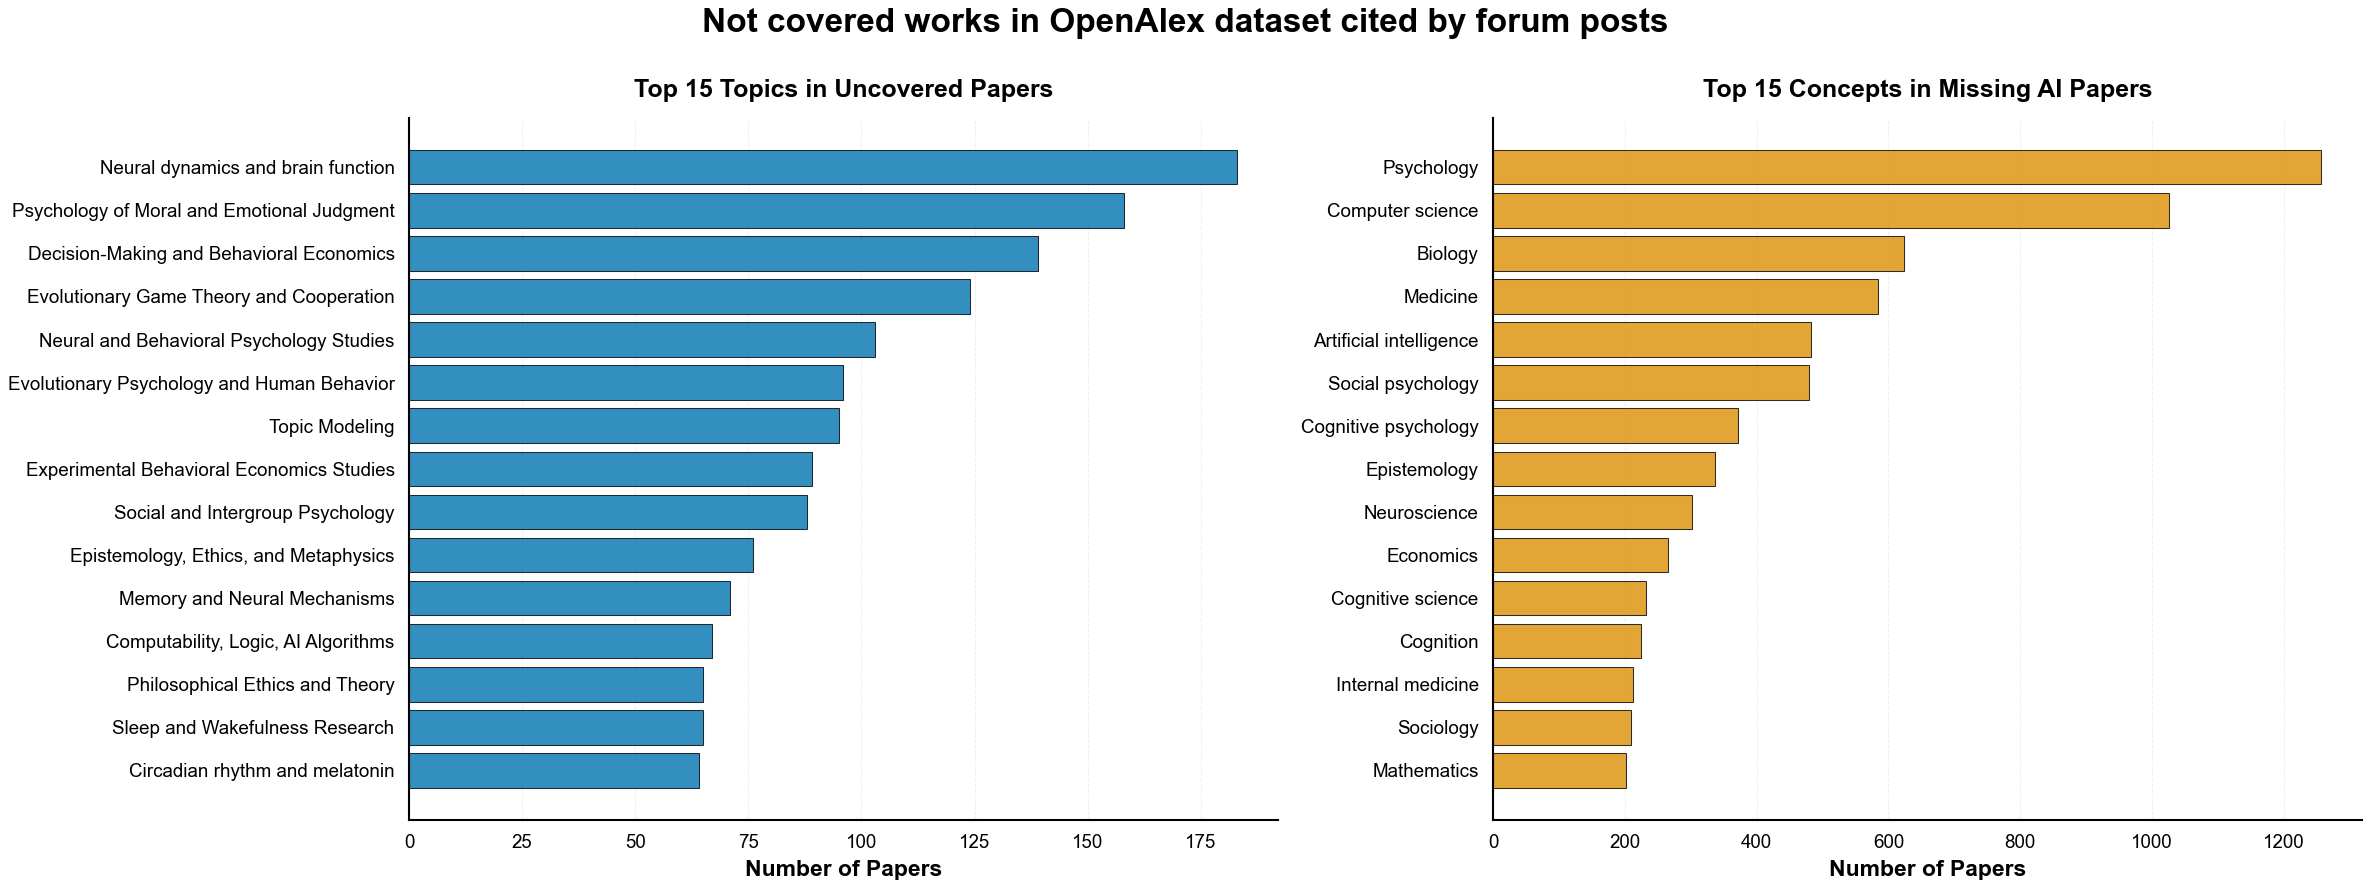

In [212]:
# =============================================================================
# VISUALIZATION
# =============================================================================

print("\n" + "="*80)
print("5️⃣  CREATING VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Set Nature-style parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica'],
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 1,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Nature color palette (colorblind-friendly)
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161', '#949494']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Not covered works in OpenAlex dataset cited by forum posts', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Top Topics
top_topics = topic_counts.most_common(15)
y_pos = range(len(top_topics))
axes[0].barh(y_pos, [t[1] for t in reversed(top_topics)], 
                color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels([t[0][:50] for t in reversed(top_topics)])
axes[0].set_xlabel('Number of Papers', fontweight='bold')
axes[0].set_title('Top 15 Topics in Uncovered Papers', 
                     fontweight='bold', pad=10)
axes[0].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)

# Plot 2: Top Concepts
top_concepts = concept_counts.most_common(15)
y_pos = range(len(top_concepts))
axes[1].barh(y_pos, [t[1] for t in reversed(top_concepts)], 
                color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([t[0][:50] for t in reversed(top_concepts)])
axes[1].set_xlabel('Number of Papers', fontweight='bold')
axes[1].set_title('Top 15 Concepts in Missing AI Papers', 
                     fontweight='bold', pad=10)
axes[1].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()

# Save as PDF (vector format for publications)
plt.savefig('missing_ai_papers_analysis.pdf', format='pdf', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to 'missing_ai_papers_analysis.pdf'")

plt.show()

In [109]:
# =============================================================================
# RECOMMENDATIONS
# =============================================================================

print("\n" + "="*80)
print("6️⃣  RECOMMENDATIONS FOR EXPANDING YOUR DATASET")
print("="*80)

print(f"""
CURRENT FILTER: topics.id:T10883 (AI Safety)

SUGGESTED ADDITIONAL TOPIC IDs TO INCLUDE:
{', '.join([f'T{tid}' for tid, _ in topic_id_counts.most_common(10)])}

OPTION A - Expand with specific topics:
filter='topics.id:T10883|{"|".join([tid for tid, _ in topic_id_counts.most_common(10)])}'

OPTION B - Use broader field filter:
filter='topics.field.id:...' (use Computer Science field)

OPTION C - Fetch these specific papers:
# Create a list of DOIs and fetch them individually
dois_to_fetch = {ai_related_dois}
for doi in dois_to_fetch:
    fetch_paper_from_openalex(doi)

SAFETY/ETHICS RELEVANCE:
- {len(ethics_related)} papers ({len(ethics_related)/len(detailed_papers)*100:.1f}%) explicitly mention safety/ethics
- These are highly relevant to AI safety discourse
- Recommend including them in your dataset
""")


6️⃣  RECOMMENDATIONS FOR EXPANDING YOUR DATASET

CURRENT FILTER: topics.id:T10883 (AI Safety)

SUGGESTED ADDITIONAL TOPIC IDs TO INCLUDE:
TT10581, TT12520, TT10315, TT11252, TT10042, TT11118, TT10028, TT10646, TT10314, TT11477

OPTION A - Expand with specific topics:
filter='topics.id:T10883|T10581|T12520|T10315|T11252|T10042|T11118|T10028|T10646|T10314|T11477'

OPTION B - Use broader field filter:
filter='topics.field.id:...' (use Computer Science field)

OPTION C - Fetch these specific papers:
# Create a list of DOIs and fetch them individually
dois_to_fetch = ['10.1007/s11238-006-9004-4', '10.1080/01621459.1995.10476620', '10.1038/nj7312-240a', '10.1371/journal.pone.0065522', '10.1002/14651858.cd000371.pub5', '10.1002/9781119993384', '10.1111/j.1753-4887.1974.tb05180.x', '10.1080/13674679908406332', '10.1521/jscp.23.5.603.50748', '10.1521/jscp.2000.19.1.56', '10.1002/9780470713853.ch2', '10.1111/j.1468-2958.2007.00293.x', '10.1056/nejmoa1307352', '10.1038/nature.2012.11535', '10.11

✓ Saved 3716 papers to 'missing_ai_papers_detailed.csv'

Columns: ['doi', 'openalex_id', 'title', 'publication_year', 'cited_by_count', 'type', 'venue', 'topic_1_id', 'topic_1_name', 'topic_1_score', 'topic_2_id', 'topic_2_name', 'topic_2_score', 'topic_3_id', 'topic_3_name', 'topic_3_score', 'all_topics', 'num_concepts', 'concepts', 'concepts_json', 'num_keywords', 'keywords', 'has_abstract', 'abstract_inverted_index']

First few rows:
                              doi  \
0       10.1007/s11238-006-9004-4   
1  10.1080/01621459.1995.10476620   
2             10.1038/nj7312-240a   
3    10.1371/journal.pone.0065522   
4  10.1002/14651858.cd000371.pub5   

                                                                                                                                      title  \
0                                                                                                   Uncommon Priors Require Origin Disputes   
1                                                 

## Unknown Genders

In [5]:
unknown_gender = combined_df[combined_df["user_gender"] == '-']
unknown_gender_counts = unknown_gender['user.username'].value_counts()
# if (unknown_gender_counts < 5).any():
unknwons = set(unknown_gender_counts.index)
unknowns_lower = {name.lower() for name in unknwons}

In [6]:
for user in unknowns_lower:
    print(user)

rcu
denreik
kohaku-none
funkycoder
lexico
rangi
jooyous
solipsist
fiddlemath
carn
zhaowei zhang
kytael
harfe
acrackedpot
elec0
expipiplusone
ar-sht
jbay
onewhofrogs
htlou
minibearrex
alvaromoret
eniscien
roxolan
cfar team
yanni
drocta
racinkc1
ahbwramc
dal
ekkolapto
gcmac
verbalshadow
furcas
9eb1
flowerfeatherfocus
spookyuser
bramflakes
edanm
en kepeig
shiroe
ratswrongaboutuap
realitygrill
avery-liu
demeter
xfrequentist
calecute
smitop
ete
irenictruth
schrodingart
tmfow
disoha
kei
kiboneu
rorschak
eugman
qbee
senarin
thetwelve
af2022
physicaleconomics
lionhearted
tanagrabeast
dentosal
caffemacchiavelli
tsang chung shu
ratcourse
lejuletre
randomini
wheelspawn
summerstay
aspiringknitter
ajfox
creatorrr
ahartntkn
askwho
jmiller
jpyykko
natural_number
hu-yichao
ndee
caesium
mnoetel
borasko
dripgrind
d𝜋
zlrth
milkandcigarettes
kingreaper
petruchio
mushroomsoup
hairyfigment
person-1
erfeyah
emr
sark
perplexed
purge
xpostah
elo
hangedman
wiserd
bayareahuman
twistingfingers
networked
nanashi
r

In [ ]:
import json
with open("../src/metadata/graphql_usernames.json", "r", encoding="utf-8") as f:
        names_data = json.load(f)

MALE_USERNAMES = names_data["MALE_USERNAMES"]
FEMALE_USERNAMES = names_data["FEMALE_USERNAMES"]

KeyError: 'MALE_NAMES'

In [ ]:
unknowns_without_male = unknowns_lower.difference(names.MALE_NAMES)
unknowns_without_female = unknowns_lower.difference(names.FEMALE_NAMES)
print(f'Unkown names that are neither in FEMALE_NAMES nor MALE_NAMES: {len(unknowns_without_male.intersection(unknowns_without_female))}')
print(unknowns_without_male.intersection(unknowns_without_female))

In [ ]:
male_names_without_unknowns = names.MALE_NAMES.difference(unknowns_lower)
print(sorted(male_names_without_unknowns))
print(sorted(names.MALE_NAMES - male_names_without_unknowns))
print(sorted(names.MALE_NAMES - names.MALE_USERNAMES))

In [ ]:
import importlib
import src.names as names
importlib.reload(names) 

In [ ]:
female_names_without_unknowns = names.FEMALE_NAMES.difference(unknowns_lower)
print(female_names_without_unknowns)
print(names.FEMALE_NAMES - female_names_without_unknowns)
print(names.FEMALE_NAMES - names.FEMALE_USERNAMES)

In [ ]:

import src.names as names
 # Force reload
print(type(names.MALE_NAMES))  # Should be <class 'set'>
print(len(names.MALE_NAMES))   # Check the size
print('yashvardhan' in names.MALE_NAMES)

In [ ]:
print(sorted(names.MALE_NAMES))

In [ ]:
purely_unknown = unknwons - names.MALE_USERNAMES

In [ ]:
purely_unknown_lower = {name.lower() for name in purely_unknown}
male_names_lower = {name.lower() for name in names.MALE_USERNAMES}
print(purely_unknown_lower.intersection(male_names_lower))

In [ ]:
all_names = list(names.FEMALE_NAMES) + list(names.MALE_NAMES)
all_names_sorted = sorted(all_names, key=len, reverse=True)

gf = []
gf_user = []
gm = []
gm_user = []

for username in unknowns_lower:
    for name in all_names_sorted:
        if len(name) > 3 and name in username:
            if name in names.FEMALE_NAMES:
                print(f"FEMALE: {username} with {name}")
                gf_user.append(username)
                gf.append(name)
            elif name in names.MALE_NAMES:
                print(f"MALE: {username} with {name}")
                gm_user.append(username)
                gm.append(name)

In [ ]:
print(gf_user)
print(len(gf_user))
print(gm_user)
print(len(gm_user))

In [ ]:
current_unknowns = unknowns_lower - set(gf_user) - set(gm_user)
for name in current_unknowns:
    print(name)

In [ ]:
perplexity = [1150.00, 1105.33, 1072.61, 1054.01, 1040.12, 1028.32, 1018.51, 1009.65, 1002.37]
topics = [10, 15, 20, 25, 30, 35, 40, 45, 50]
log_likelihood = [-126311522.90,-125601505.71, -125062974.37, -124749334.57, -124511617.32,  -124307203.07, -124135376.41, -123978846.41, -123849036.87]
plt.plot(topics, perplexity)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(topics, perplexity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(topics, log_likelihood, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()